TO DO

(1) Do we systematically throw out parts of the cloud which have low Pfrac by using the 3-sigma cutoff? 

(2) Do binned statistics to create Pfrac as a function of column density (whole cloud as well as Ridge and sub-filaments.Reference: Figure 15, Planck 2019

(3) Refer to Fissel 2016 PvsN or PvsS as a function of temperature for heated sightlines to understand why similar column density sightlines in Ridge versus sub-filaments are different.

 Explore NvsT to find outliers and see where they lie in the map. BLAST did not have sufficient resolution to probe the highest column density and SOFIA might be able to address that. Juan referred to Planck XII figure 13 that conducted a similar analysis.

TO DO 

(1) Concerning the binning, I think what we should have is the scatter like you had before but with now with a running means binned along the x axis. We should also show the scatter the data as error bars.

(2) Related to Pvs N, do you see a clear correlation between N & T for the ridge? We did see a clear correlation between P and N. So we should also check whether there is a correlation between P and T.  This would help in understanding if N is indeed important in determining P

Importing the required libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import aplpy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
from astropy.stats import bootstrap
import matplotlib.ticker as ticker
plt.rcParams.update({'font.size': 18})
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
# %matplotlib widget


Writing the required functions

In [2]:
def generate_RA_DEC_mesh(hdr):
    """generate_RA_DEC_mesh

    Generates the RA and DEC grid for the intensity map

    """
    if 'CDELT1' in hdr.header:
        RA_delt = hdr.header['CDELT1']
        DEC_delt = hdr.header['CDELT2']

    if 'CD1_1' in hdr.header:
        RA_delt = hdr.header['CD1_1']
        DEC_delt = hdr.header['CD2_2']

    RA_ref = (hdr.header['CRPIX1'])
    DEC_ref = (hdr.header['CRPIX2'])
    RA_ref_value = hdr.header['CRVAL1']
    DEC_ref_value = hdr.header['CRVAL2']
    RA_axis_len = hdr.header['NAXIS1']
    DEC_axis_len = hdr.header['NAXIS2']

    RA_axis = np.arange(1,RA_axis_len+1)
    DEC_axis = np.arange(1,DEC_axis_len+1)
    DEC_axis_modified = np.arange(1,RA_axis_len+1)
    
    DEC_array = (DEC_axis - DEC_axis_len/2)*DEC_delt + DEC_ref_value
    DEC_array_modified = (DEC_axis_modified - RA_axis_len/2)*DEC_delt + DEC_ref_value
    RA_array = RA_ref_value-(RA_axis - RA_axis_len/2)*(RA_delt*(-1)/np.cos(DEC_array_modified*0.01745))

    # #making a meshgrid from the arrays
    DEC_grid,RA_grid = np.meshgrid(DEC_array,RA_array , sparse=False, indexing='ij')
    return DEC_grid,RA_grid

def Calc_l(ra1,dec1,ra2,dec2):
    """Calc_l

    Calculates the angular seperation between two points on the celestial sphere

    """
    c1 = SkyCoord(ra1,dec1,unit = 'deg')
    c2 = SkyCoord(ra2,dec2,unit = 'deg')
    sep = c1.separation(c2)
    return sep.arcminute
    
def wrapper(Angle_grid):
    """wrapper

    Generates an array with values between -90 to 90

    """
    while ((np.nanmax(Angle_grid)>90) or (np.nanmin(Angle_grid)<-90)):
        Angle_selector =Angle_grid>90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] - 180
        Angle_selector = Angle_grid<-90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] + 180
    return Angle_grid
    
def lin_fit(x, a, b):
    """lin_fit

    Funtion for fitting a linear regression with one parameters.

    """
    return a + b*x

def DoubleParamFunc(X, a, b, c):
    """DoubleParamFunc

    Funtion for fitting a linear regression with two paramters.

    """
    x,y = X
    return a + b*x + c*y

def curve_fitting(x):
    """curve_fitting

    Generating a double parameter fit.

    """
    param, param_cov = curve_fit(DoubleParamFunc,(x[:,2],x[:,1]),x[:,0])
    return param

def remove_nan(array1,array2):
    """remove_nan

    Function for removing the nan values in two connected arrays

    """
    selector = ~np.isnan(array1)
    array1_fil = array1[selector]
    array2_fil = array2[selector]

    selector = ~np.isnan(array2_fil)
    array1_fil = array1_fil[selector]
    array2_fil = array2_fil[selector]
    return array1_fil,array2_fil


def binning_data(array1,array2,delt):
    """binning_data

    Function for binning data

    """
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
    plt.figure(figsize=(10,6))
    plt.scatter(levels_centres,binned_data)
      
def binning_datav1(array1,array2,delt_bin):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    error_bar = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(10**temp_array2))
    binned_data = np.array(binned_data)
    error_bar = np.array(error_bar)
    plt.figure(figsize=(12,8))
    plt.errorbar(10**levels_centres,10**binned_data,yerr=error_bar,c='grey')
    plt.scatter(10**levels_centres,10**binned_data,s = 40,c='r')
    plt.plot(10**levels_centres,10**binned_data,c='k')

def binning_datav2(array1,array2,delt_bin):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    error_bar = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(10**temp_array2))
    binned_data = np.array(binned_data)
    error_bar = np.array(error_bar)
    # plt.figure(figsize=(10,6))
    plt.errorbar(10**levels_centres,10**binned_data,yerr=error_bar,c='grey')
    plt.scatter(10**levels_centres,10**binned_data,s = 40,c='r')
    plt.plot(10**levels_centres,10**binned_data,c='k')

def binning_datav3(array1,array2,delt_bin):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    error_bar = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(10**temp_array2))
    level_bins = np.linspace(np.amin(levels_centres),np.amax(levels_centres),10)
    binned_data = np.array(binned_data)
    error_bar = np.array(error_bar)
    levels_centres = np.array(levels_centres)
    param, PS_param_cov = curve_fit(lin_fit, levels_centres, binned_data,sigma=error_bar)
    PS_FitFunc = lin_fit(level_bins,param[0],param[1])
    return param,level_bins,PS_FitFunc



Importing the fits files

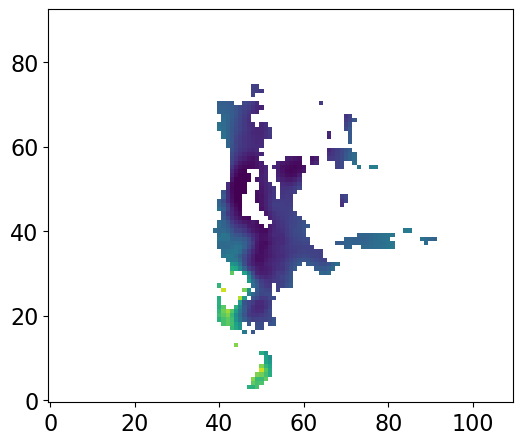

In [3]:
########## importing and testing the file
FITS1 = '../FITS_file/CygX_E_OTFMAP.fits'
FITS2 = '../FITS_file/DR21_NH2_Repr.fits'
FITS3 = '../FITS_file/DR21_Tdust_Repr.fits'
FITS4 = '../FITS_file/DR21_IRAC4_Repr.fits'
FITS5 = '../FITS_file/DR21_Her250_Repr.fits'
hdul = fits.open(FITS1)
hdul2 = fits.open(FITS2)
hdul3 = fits.open(FITS3)
hdul4 = fits.open(FITS4)
hdul5 = fits.open(FITS5)
# print(hdul.info())



MapStokesI = hdul[0]
MapStokesIError = hdul[1]
MapStokesQ = hdul[2]
MapStokesU = hdul[4]
MapDebPol = hdul[8]
MapDebPolError = hdul[9]
MapPolAngleNonRotated = hdul[10]
MapPolAngle = hdul[11]
MapPolAngleError = hdul[12]
MapPolFlux = hdul[13]
MapPolFluxError = hdul[14]
MapColumndensity = hdul2[0]
MapTemperature = hdul3[0]
Map8Micron = hdul4[0]
MapHer250 = hdul5[0]



MapPolSNR = MapDebPol.copy()
BlankedMapPol = MapDebPol.copy()
BlankedMapPolAngle = MapPolAngle.copy()
BlankedMapPolAngleError = MapPolAngleError.copy()
BlankedMapPolAngleNonRotated = MapPolAngleNonRotated.copy() 
BlankedMapStokesI = MapStokesI.copy()
BlankedMapStokesQ = MapStokesQ.copy()
BlankedMapStokesU = MapStokesU.copy()
BlankedMapColumnDensity = MapColumndensity.copy()
BlankedMapTemperature = MapTemperature.copy()
BlankedMap8Mircon = Map8Micron.copy()
BlankedMapHer250 = MapHer250.copy()



######## taking points only with singal to noise ratio more than 3
MapPolSNR.data[:] = np.nan
MapPolSNR.data = MapDebPol.data/MapDebPolError.data


Selector = (MapPolSNR.data < 3)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan



############## removing any points with pfrac above 50
Selector = (BlankedMapPol.data>50)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan


############ removing any data points with I/I_error < 100
Selector = MapStokesI.data/MapStokesIError.data < 100
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan


BlankedMapColumnDensity.data = BlankedMapColumnDensity.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapTemperature.data = BlankedMapTemperature.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMap8Mircon.data = BlankedMap8Mircon.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapPolAngleError.data = BlankedMapPolAngleError.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapHer250.data = BlankedMapHer250.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)





plt.figure(figsize=(6,6))
# plt.imshow(np.log10(MapHer250.data),origin='lower',vmin = 0 , vmax = 3)
plt.imshow(BlankedMapTemperature.data,origin='lower',vmin = 20, vmax = 40)
plt.show()



Creating the angular dispersion map and debiasing it

In [4]:
############## generating the RA and DEC mesh
DEC_grid,RA_grid = generate_RA_DEC_mesh(hdul[0])
seperation = MapPolAngle.copy()


set_delta = 0.5   # in arcminute
S_map = BlankedMapPolAngle.copy()
sigma_S_map = BlankedMapPolAngleError.copy()

for i in range(RA_grid.shape[0]):
    for j in range(RA_grid.shape[1]):

        ##### seperation filter
        seperation.data = Calc_l(RA_grid[i,j],DEC_grid[i,j],RA_grid,DEC_grid)
        seperation_selector = (seperation.data<0.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data>1.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data >0)

        ##### making the dispersion map
        tempa = BlankedMapStokesQ.data*BlankedMapStokesU.data[i,j] - BlankedMapStokesQ.data[i,j]*BlankedMapStokesU.data
        tempb = BlankedMapStokesQ.data*BlankedMapStokesQ.data[i,j] + BlankedMapStokesU.data*BlankedMapStokesU.data[i,j]
        AngleDiff_v2 = 0.5 * (180/np.pi)*np.arctan2(tempa,tempb)
        S = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
        S_map.data[i,j] = S

        ##### making the dispersion error map
        sigma_S = np.nanmean(BlankedMapPolAngleError.data[seperation_selector]**2)**0.5
        sigma_S_map.data[i,j] = sigma_S


S_map_deb = S_map.copy()
S_map_deb.data = np.sqrt(S_map.data**2 - sigma_S_map.data**2)


C:\Users\DELL\AppData\Local\Temp\ipykernel_7684\3070498281.py:25: RuntimeWarning: Mean of empty slice
  S = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
C:\Users\DELL\AppData\Local\Temp\ipykernel_7684\3070498281.py:29: RuntimeWarning: Mean of empty slice
  sigma_S = np.nanmean(BlankedMapPolAngleError.data[seperation_selector]**2)**0.5
C:\Users\DELL\AppData\Local\Temp\ipykernel_7684\3070498281.py:34: RuntimeWarning: invalid value encountered in sqrt
  S_map_deb.data = np.sqrt(S_map.data**2 - sigma_S_map.data**2)


Plotting fits files with aplpy

In [5]:
# LogMapColumnDensity = MapColumndensity.copy()
# LogMapColumnDensity.data = np.log10(LogMapColumnDensity.data)


# plt.figure(figsize=(15,15))

# fig = plt.subplots(figsize=(15,15))
# scuba = aplpy.FITSFigure(S_map_deb)
# # plt.imshow(MapHer250.data,origin='lower',vmin = 0 , vmax = 250)
# scuba.ticks.set_xspacing(0.1) # number in degrees

# scuba.show_colorscale(cmap='default',vmin = 0,vmax = 55)

# scuba.ticks.show()
# scuba.ticks.show_x()
# scuba.ticks.show_y()
# # aplpy.Colorbar.show(location='right', width=0.2, pad=0.05, ticks=None,)
# scuba.add_colorbar(location='right', width=0.2, pad=0.15, ticks=None,axis_label_text= 'angle dispersion')
# # plt.tight_layout()
# plt.show()


Saving data into csv files

In [6]:
# DEC_array = DEC_grid.flatten()
# RA_array = RA_grid.flatten()
# StokesI_array = BlankedMapStokesI.data.flatten()
# S_array = S_map_deb.data.flatten()
# P_array = BlankedMapPol.data.flatten()
# nh2_array = BlankedMapColumnDensity.data.flatten()
# temperature_array = BlankedMapTemperature.data.flatten()
# PolAngleNonRotated_array = BlankedMapPolAngleNonRotated.data.flatten()
# micron8_array = BlankedMap8Mircon.data.flatten()
# df = pd.DataFrame({'RA': RA_array, 'DEC': DEC_array,'P':P_array, 'PolAng': PolAngleNonRotated_array ,'I': StokesI_array,'S':S_array,'ColumnDen':nh2_array,'Temperature':temperature_array,'8micron':micron8_array})
# df.to_csv('..\data\data_dr21.csv',sep=chr(44))

whole region analysis

C : 10.703068578260197
s index : -0.29055734604289624
nh2 index : -0.433980737594994
(10230,)
(2558,)


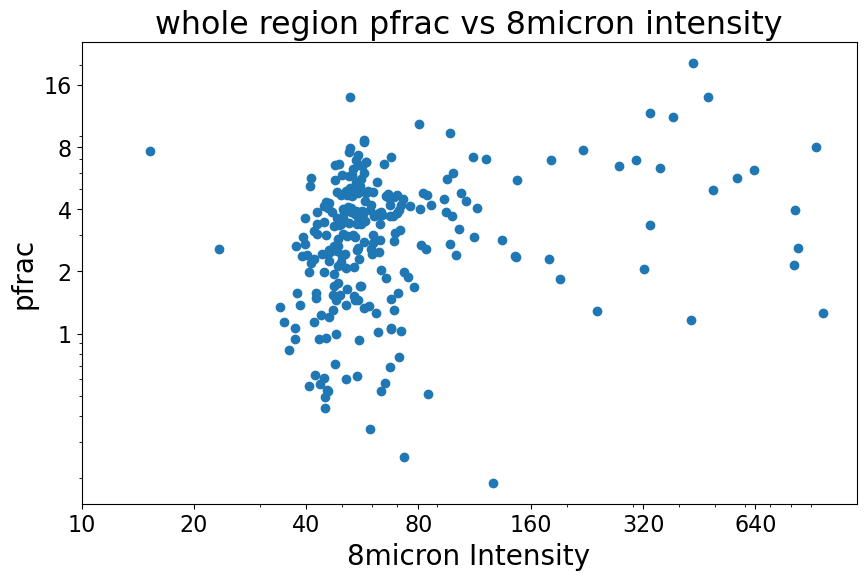

In [51]:
############### changing data to array
s_array = S_map_deb.data.flatten()
p_array = BlankedMapPol.data.flatten()
I_array = BlankedMapStokesI.data.flatten()
nh2_array = BlankedMapColumnDensity.data.flatten()
micron8_array = BlankedMap8Mircon.data.flatten()


############# making the data independent
s_array_ind = s_array.copy()
s_array_ind = s_array_ind[::4]
p_array_ind = p_array.copy()
p_array_ind = p_array_ind[::4]
I_array_ind = I_array.copy()
I_array_ind = I_array_ind[::4]
nh2_array_ind = nh2_array.copy()
nh2_array_ind = nh2_array_ind[::4]
micron8_array_ind = micron8_array.copy()
micron8_array_ind = micron8_array_ind[::4]


########## taking log 10 of the data
log_s = np.log10(s_array_ind)
log_p = np.log10(p_array_ind)
log_I = np.log10(I_array_ind)
log_nh2 = np.log10(nh2_array_ind)
log_8micron = np.log10(micron8_array_ind)

######## making bins of the array for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
micron8_min = np.nanmin(log_8micron)
micron8_max = np.nanmax(log_8micron)  

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)
micron8_bins = np.linspace(micron8_min,micron8_max,100)

############ fitting the data 
df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I,'lognh2':log_nh2,'log_8micron':log_8micron})
df_log = df_log.dropna()

########### single parameter fitting
PS_param, PS_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc = lin_fit(s_bins,PS_param[0],PS_param[1])

PI_param, PI_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc = lin_fit(I_bins,PI_param[0],PI_param[1])

Pnh2_param, Pnh2_param_cov = curve_fit(lin_fit, df_log['lognh2'], df_log['logp'])
Pnh2_FitFunc = lin_fit(nh2_bins,Pnh2_param[0],Pnh2_param[1])

########### Double parameter fitting
# p0 = -0.2278,-0.3994,2.
# PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
# print('C :',PSI_param_lower[0])
# print('s index :',PSI_param_lower[1])
# print('I index :',PSI_param_lower[2])


p0 = -0.2278, -0.8567, 2.
PSNH2_param_lower, PSNH2_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']), df_log['logp'],p0)
print('C :',PSNH2_param_lower[0])
print('s index :',PSNH2_param_lower[1])
print('nh2 index :',PSNH2_param_lower[2])


################## plot absolute values

# fig = plt.subplots(figsize =(10, 6))
# ax1 = plt.subplot(111)
# ax1.scatter(s_array_ind,p_array_ind)
# label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_param[1],C = PS_param[0],linebreak='\n')
# # ax1.plot(10**s_bins,10**PS_FitFunc,'r',linewidth=3,label = label_temp)
# ax1.set_title("whole region pfrac vs S")
# ax1.set_ylabel('pfrac',fontdict={'fontsize':20})
# ax1.set_xlabel('S',fontdict={'fontsize':20})
# ax1.set_xscale('log')
# ax1.set_yscale('log')
# ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
# ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
# ax1.set_yticks(2**np.array([0,1,2,3,4]))
# ax1.set_xticks(2**np.array([0,1,2,3,4,5,6,7]))


# # # fig = plt.subplots(figsize =(12, 8))
# # # ax2 = plt.subplot(111)
# # # ax2.scatter(log_I,log_p)
# # # label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_param[1],C = PI_param[0],linebreak='\n')
# # # ax2.plot(I_bins,PI_FitFunc,'r',linewidth=3,label = label_temp)
# # # # ax2.set_title("whole region log p X log I")
# # # ax2.set_ylabel('log p')
# # # ax2.set_xlabel('log I')

# fig = plt.subplots(figsize =(10, 6))
# ax3 = plt.subplot(111)
# ax3.scatter(nh2_array_ind,p_array_ind)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
# # ax3.plot(10**nh2_bins,10**Pnh2_FitFunc,'r',linewidth=3,label = label_temp)
# ax3.set_title("whole region pfrac vs NH2")
# ax3.set_ylabel('pfrac',fontdict={'fontsize':20})
# ax3.set_xlabel('NH2',fontdict={'fontsize':20})
# ax3.set_xscale('log')
# ax3.set_yscale('log')
# ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
# ax3.set_yticks(2**np.array([0,1,2,3,4]))



fig = plt.subplots(figsize =(10, 6))
ax4 = plt.subplot(111)
print(micron8_array.shape)
print(p_array_ind.shape)
ax4.scatter(micron8_array_ind,p_array_ind)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
ax4.set_title("whole region pfrac vs 8micron intensity")
ax4.set_ylabel('pfrac',fontdict={'fontsize':20})
ax4.set_xlabel('8micron Intensity',fontdict={'fontsize':20})
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax4.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax4.set_yticks(2**np.array([0,1,2,3,4]))
ax4.set_xticks(np.array([10,20,40,80,160,320,640]))

# fig = plt.subplots(figsize =(10, 6))
# ax5 = plt.subplot(111)
# ax5.scatter(nh2_array_ind,p_array_ind*s_array_ind)
# # label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
# ax5.set_title("whole region pfrac*S vs NH2")
# ax5.set_ylabel('pfrac*S',fontdict={'fontsize':20})
# ax5.set_xlabel('NH2',fontdict={'fontsize':20})
# ax5.set_xscale('log')
# ax5.set_yscale('log')
# ax5.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
# ax5.set_yticks(np.array([1,5,10,20,40,80,160,320]))

# # ax1.legend()
# # ax3.legend()
# plt.tight_layout()
# plt.rcParams.update({'font.size': 19})
# plt.show()

In [8]:
#################### plotting the graphs
    
# fig = plt.subplots(figsize =(10, 6))
# ax1 = plt.subplot(111)
# ax1.scatter(log_s,log_p)
# label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_param[1],C = PS_param[0],linebreak='\n')
# # ax1.plot(s_bins,PS_FitFunc,'r',linewidth=3,label = label_temp)
# # ax1.set_title("whole region Polarization fraction vs S")
# ax1.set_ylabel('log pfrac',fontdict={'fontsize':20})
# ax1.set_xlabel('log S',fontdict={'fontsize':20})

# # fig = plt.subplots(figsize =(12, 8))
# # ax2 = plt.subplot(111)
# # ax2.scatter(log_I,log_p)
# # label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_param[1],C = PI_param[0],linebreak='\n')
# # ax2.plot(I_bins,PI_FitFunc,'r',linewidth=3,label = label_temp)
# # # ax2.set_title("whole region log p X log I")
# # ax2.set_ylabel('log p')
# # ax2.set_xlabel('log I')

# fig = plt.subplots(figsize =(10, 6))
# ax3 = plt.subplot(111)
# ax3.scatter(log_nh2,log_p)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
# ax3.plot(nh2_bins,Pnh2_FitFunc,'r',linewidth=3,label = label_temp)
# # ax3.set_title("whole region log p X log nh2")
# ax3.set_ylabel('log pfrac',fontdict={'fontsize':20})
# ax3.set_xlabel('log Column density',fontdict={'fontsize':20})

# fig = plt.subplots(figsize =(10, 6))
# ax4 = plt.subplot(111)
# ax4.scatter(log_8micron,log_p)
# # label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
# # ax4.set_title("whole region log pfrac vs log 8micron intensity")
# ax4.set_ylabel('log pfrac',fontdict={'fontsize':20})
# ax4.set_xlabel('log 8micron Intensity',fontdict={'fontsize':20})

# fig = plt.subplots(figsize =(10, 6))
# ax5 = plt.subplot(111)
# ax5.scatter(np.log10(nh2_array_ind),np.log10(p_array_ind*s_array_ind))
# # label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
# # ax4.set_title("whole region log pfrac vs log 8micron intensity")
# ax5.set_ylabel('log pfrac*S',fontdict={'fontsize':20})
# ax5.set_xlabel('log Column density',fontdict={'fontsize':20})

# ax1.legend()
# ax3.legend()
# # # plt.legend()
# plt.tight_layout()
# plt.rcParams.update({'font.size': 19})
# plt.show()



binned data analysis whole region 

C:\Users\DELL\AppData\Local\Temp\ipykernel_7684\1544493144.py:82: RuntimeWarning: Mean of empty slice
  bin_centres.append(np.nanmean(sorted1[i*bin_size:i*bin_size+bin_size]))
C:\Users\DELL\AppData\Local\Temp\ipykernel_7684\1544493144.py:83: RuntimeWarning: Mean of empty slice
  data_binned.append(np.nanmean(sorted2[i*bin_size:i*bin_size+bin_size]))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


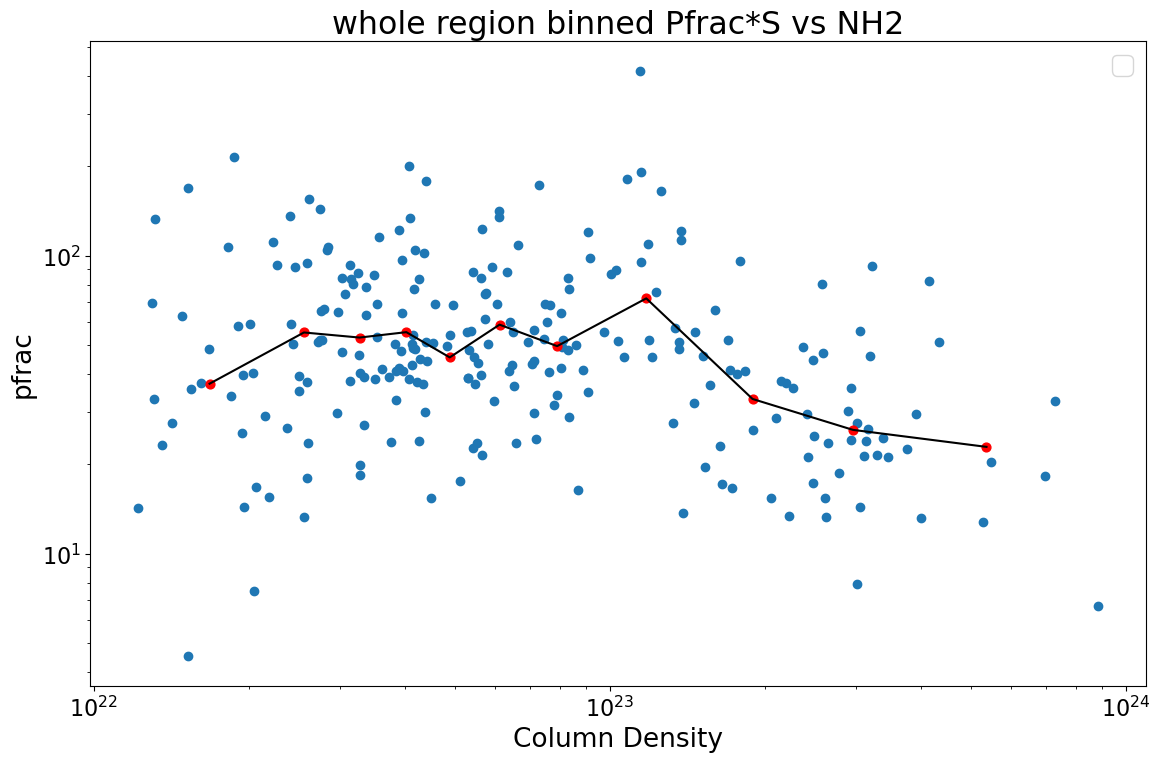

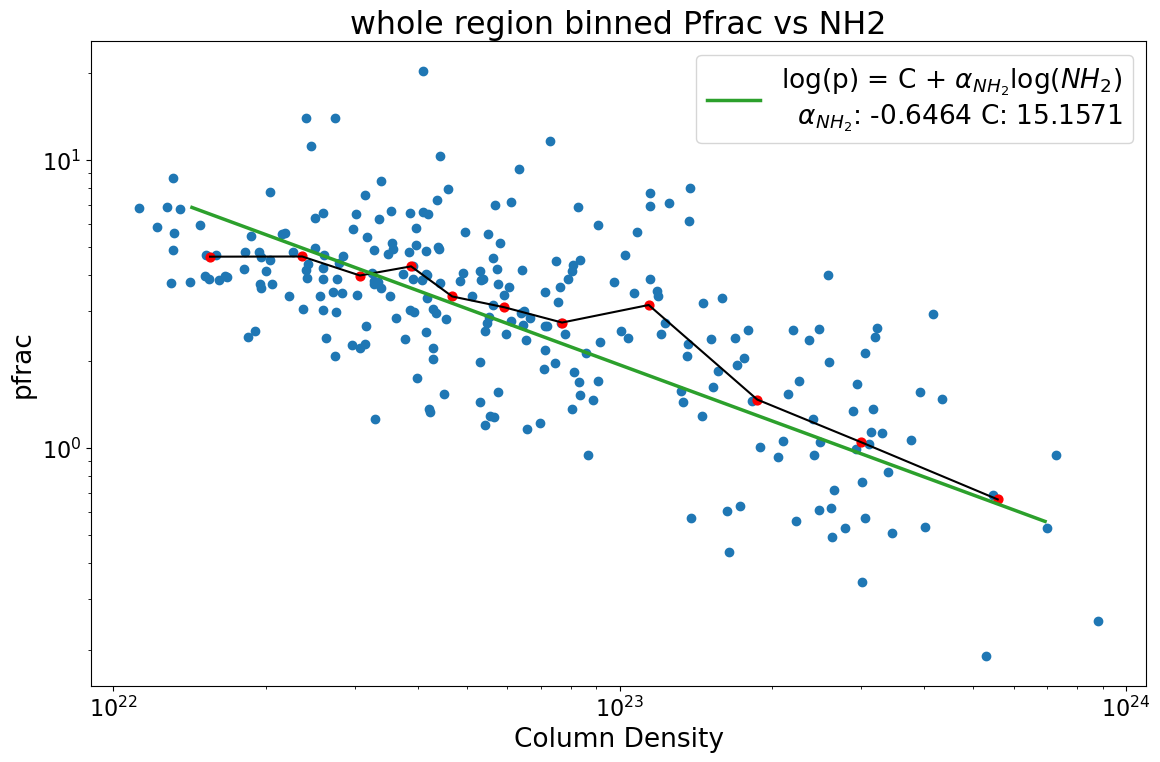

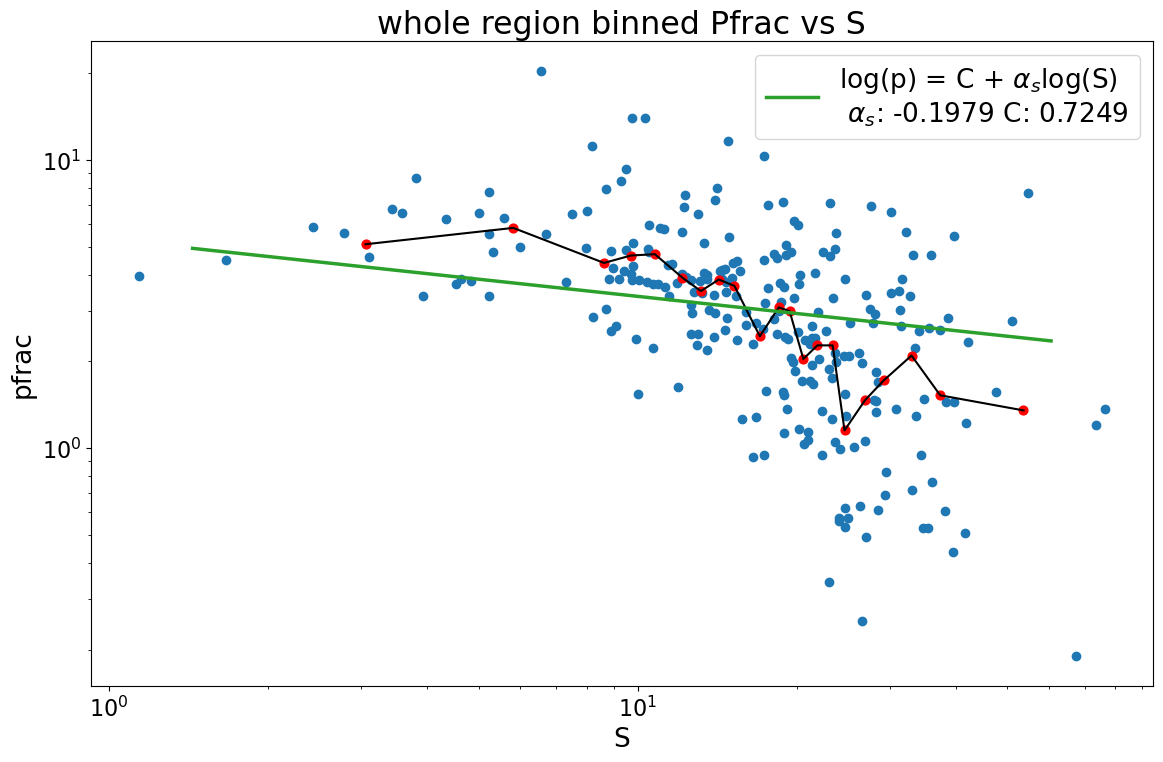

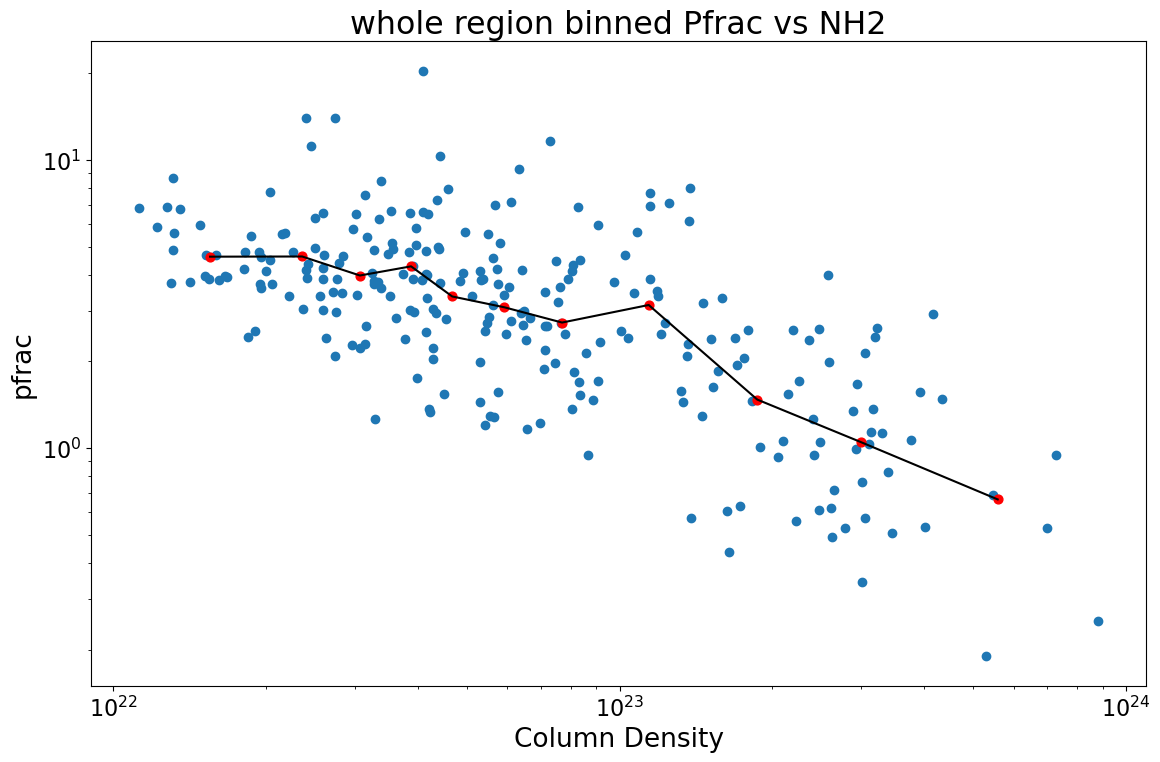

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


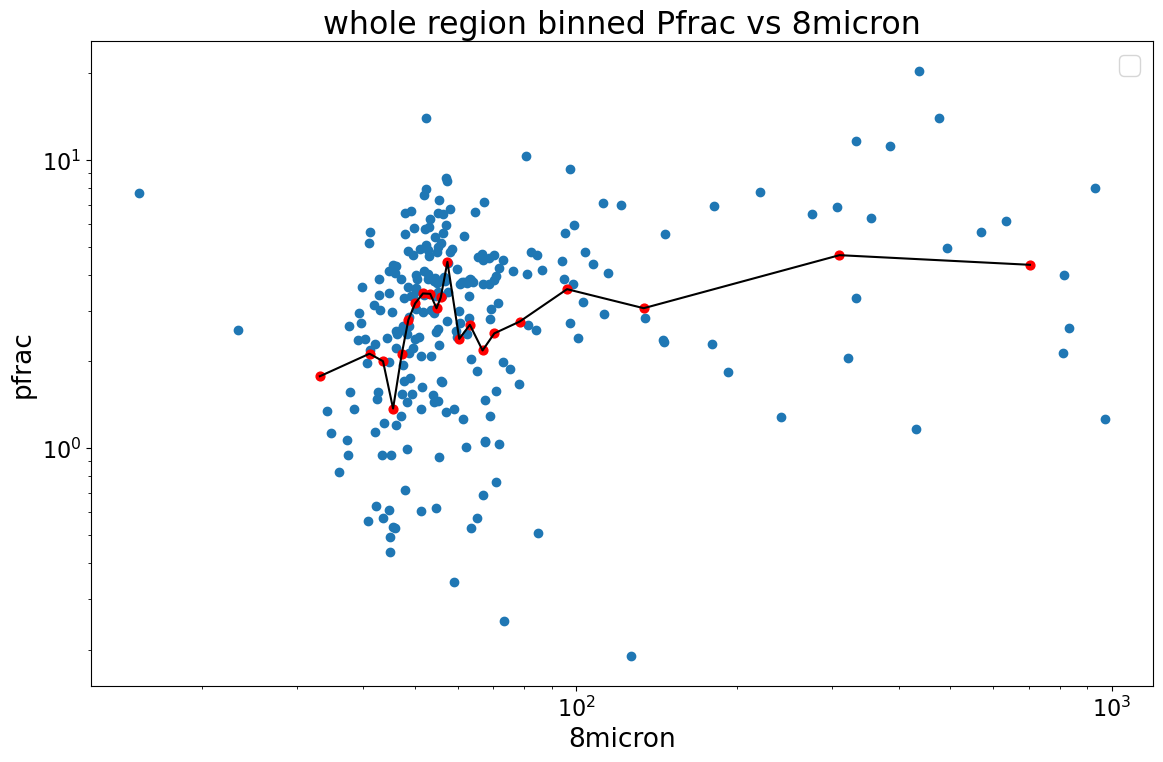

In [52]:

##################### binning data

def binning_datav1(array1,array2,delt_bin):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    error_bar = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(10**temp_array2))
    binned_data_bins = np.linspace(np.amin(binned_data),np.amax(binned_data),10)
    binned_data = np.array(binned_data)
    error_bar = np.array(error_bar)
    # plt.figure(figsize=(10,6))
    cmap_reversed = matplotlib.cm.get_cmap('jet')
    plt.figure()
    plt.errorbar(10**levels_centres,10**binned_data,yerr=error_bar,c='grey')
    plt.scatter(10**levels_centres,10**binned_data,s = 40,c='r')
    plt.plot(10**levels_centres,10**binned_data,label = 'bins :' + str(delt_bin),c='k')

def binning_datav2(array1,array2,delt_bin):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    error_bar = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(10**temp_array2))
    binned_data_bins = np.linspace(np.amin(binned_data),np.amax(binned_data),10)
    binned_data = np.array(binned_data)
    error_bar = np.array(error_bar)
    # plt.figure(figsize=(10,6))
    cmap_reversed = matplotlib.cm.get_cmap('jet')
    plt.errorbar(10**levels_centres,10**binned_data,yerr=error_bar,c='grey')
    plt.scatter(10**levels_centres,10**binned_data,s = 40,c='r')
    plt.plot(10**levels_centres,10**binned_data,c='k')


def binning_datav3(array1,array2,delt_bin):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    error_bar = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(10**temp_array2))
    level_bins = np.linspace(np.amin(levels_centres),np.amax(levels_centres),10)
    binned_data = np.array(binned_data)
    error_bar = np.array(error_bar)
    levels_centres = np.array(levels_centres)
    param, PS_param_cov = curve_fit(lin_fit, levels_centres, binned_data,sigma=error_bar)
    PS_FitFunc = lin_fit(level_bins,param[0],param[1])
    return param,10**level_bins,10**PS_FitFunc

def binning_equal(array1,array2,bins):
    filtered1,filtered2 = remove_nan(array1,array2)
    def sortlinked(array1,array2):
        sort = np.argsort(array1)
        return array1[sort],array2[sort]
    bin_centres = []
    data_binned = []
    error_bar = []
    sorted1,sorted2 = sortlinked(filtered1,filtered2)
    bin_size = int((sorted2.shape[0])/bins)
    
    for i in range(0,bins+2):
        bin_centres.append(np.nanmean(sorted1[i*bin_size:i*bin_size+bin_size]))
        data_binned.append(np.nanmean(sorted2[i*bin_size:i*bin_size+bin_size]))
        error_bar.append(np.nanstd(10**sorted2))
    bin_centres = np.array(bin_centres)
    data_binned = np.array(data_binned)
    error_bar = np.array(error_bar)
    cmap_reversed = matplotlib.cm.get_cmap('jet')
    # plt.errorbar(10**bin_centres,10**data_binned,yerr=error_bar,c='grey')
    plt.scatter(10**bin_centres,10**data_binned,s = 40,c='r')
    plt.plot(10**bin_centres,10**data_binned,c='k')


# plt.figure(figsize=(12,8))
# plt.scatter(nh2_array_ind,p_array_ind*s_array_ind)
# binning_datav2(np.log10(nh2_array_ind),np.log10(p_array_ind*s_array_ind),20)
# plt.title('whole region binned Pfrac*S vs NH2')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Column Density')
# plt.ylabel('pfrac*S')
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(10,6))
# binning_datav2(nh2_array_ind,p_array_ind,10)
# binning_datav2(nh2_array_ind,p_array_ind,20)
# plt.scatter(nh2_array_ind,p_array_ind,c ='g')
# plt.title('whole region binned Pfrac vs NH2')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Column Density')
# plt.ylabel('pfrac')
# plt.tight_layout()
# plt.legend()
# plt.show()




plt.figure(figsize=(12,8))
plt.scatter(nh2_array_ind,p_array_ind*s_array_ind)
binning_equal(np.log10(nh2_array_ind),np.log10(p_array_ind*s_array_ind),10)
# param,x,y = binning_datav3(log_nh2,log_p,10)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = param[1],C = param[0],linebreak='\n')
# plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('whole region binned Pfrac*S vs NH2')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Column Density')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()


plt.figure(figsize=(12,8))
plt.scatter(nh2_array_ind,p_array_ind)
binning_equal(log_nh2,log_p,10)
param,x,y = binning_datav3(log_nh2,log_p,10)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('whole region binned Pfrac vs NH2')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Column Density')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()
plt.show()


plt.figure(figsize=(12,8))
plt.scatter(s_array_ind,p_array_ind)
binning_equal(log_s,log_p,20)
param,x,y = binning_datav3(log_s,log_p,10)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('whole region binned Pfrac vs S')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()
plt.show()

nh2_array_ind,p_array_ind = remove_nan(nh2_array_ind,p_array_ind)
log_nh2,log_p = remove_nan(log_nh2,log_p)
plt.figure(figsize=(12,8))
plt.scatter(nh2_array_ind,p_array_ind)
binning_equal(log_nh2,log_p,10)
# param,x,y = binning_datav3(log_nh2[:10],log_p[:10],10)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = param[1],C = param[0],linebreak='\n')
# plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('whole region binned Pfrac vs NH2')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Column Density')
plt.ylabel('pfrac')
plt.tight_layout()
# plt.legend()
plt.show()


log_p = np.array(df_log['logp'])
log_8micron = np.array(df_log['log_8micron'])

plt.figure(figsize=(12,8))
plt.scatter(10**log_8micron,10**log_p)
binning_equal(log_8micron,log_p,20)
plt.title('whole region binned Pfrac vs 8micron')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('8micron')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()
plt.show()


Bootstrap error estimation of the whole region.

In [10]:
s_whole_array = S_map_deb.data.flatten()
p_whole_array = BlankedMapPol.data.flatten()
nh2_whole_array = BlankedMapColumnDensity.data.flatten()


log_s = np.log(s_whole_array)
log_p = np.log(p_whole_array)
log_nh2 = np.log(nh2_whole_array)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()
bootarr = np.array(df_log)


bootresult = bootstrap(bootarr,1000,bootfunc=curve_fitting)
print('error in alpha_s',np.std(bootresult[:,1]))
print('error in alpha_nh2',np.std(bootresult[:,2]))


error in alpha_s 0.019103682569011748
error in alpha_nh2 0.035044241348703105


Dividing the whole region into sub-regions

In [11]:
def line_1(x, y):
    top_x = 309.9258719
    top_y = 42.4556451
    bottom_x = 309.7452960
    bottom_y =   42.4556451
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_2(x, y):
    top_x = 309.7838598
    top_y = 42.4569364
    bottom_x = 309.7792727
    bottom_y =  42.3127837
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_3(x, y):
    top_x = 309.7468561
    top_y = 42.4529922
    bottom_x = 309.7507272
    bottom_y =  42.4299500
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_4(x, y):
    top_x = 309.7507272
    top_y = 42.4305231
    bottom_x = 309.7108001
    bottom_y =  42.4094674
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_5(x, y):
    top_x = 309.7108001
    top_y = 42.4094674
    bottom_x = 309.699191
    bottom_y =  42.3710874
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

I_ridge_plus_fill_right= BlankedMapStokesI.copy()
p_ridge_plus_fill_right = BlankedMapPol.copy()
s_ridge_plus_fill_right = S_map_deb.copy()
nh2_ridge_plus_fill_right = BlankedMapColumnDensity.copy()
micron8_ridge_plus_fill_right = BlankedMap8Mircon.copy()
temp_ridge_plus_fill_right = BlankedMapTemperature.copy()

I_outflow = BlankedMapStokesI.copy()
p_outflow = BlankedMapPol.copy()
s_outflow = S_map_deb.copy()
nh2_outflow = BlankedMapColumnDensity.copy()
micron8_outflow = BlankedMap8Mircon.copy()
temp_outflow = BlankedMapTemperature.copy()


selector = (line_1(RA_grid,DEC_grid)<0)*(line_2(RA_grid,DEC_grid)<0)
I_ridge_plus_fill_right.data[selector] = np.nan
p_ridge_plus_fill_right.data[selector] = np.nan
s_ridge_plus_fill_right.data[selector] = np.nan
nh2_ridge_plus_fill_right.data[selector] = np.nan
micron8_ridge_plus_fill_right.data[selector] = np.nan
temp_ridge_plus_fill_right.data[selector] = np.nan

selector = ~selector
I_outflow.data[selector] = np.nan
p_outflow.data[selector] = np.nan
s_outflow.data[selector] = np.nan
nh2_outflow.data[selector] = np.nan
micron8_outflow.data[selector] = np.nan
temp_outflow.data[selector] = np.nan

I_fil_right = I_ridge_plus_fill_right.copy()
p_fil_right = p_ridge_plus_fill_right.copy()
s_fil_right = s_ridge_plus_fill_right.copy()
nh2_fil_right = nh2_ridge_plus_fill_right.copy()
micron8_fil_right = micron8_ridge_plus_fill_right.copy()
temp_fil_right = temp_ridge_plus_fill_right.copy()

I_ridge = I_ridge_plus_fill_right.copy()
p_ridge = p_ridge_plus_fill_right.copy()
s_ridge = s_ridge_plus_fill_right.copy()
nh2_ridge = nh2_ridge_plus_fill_right.copy()
micron8_ridge = micron8_ridge_plus_fill_right.copy()
temp_ridge = temp_ridge_plus_fill_right.copy()

selector = (line_1(RA_grid,DEC_grid)>0)+ (line_3(RA_grid,DEC_grid)<0)*(line_4(RA_grid,DEC_grid)>0) + (line_5(RA_grid,DEC_grid)>0)
  
I_ridge.data[selector] = np.nan
p_ridge.data[selector] = np.nan
s_ridge.data[selector] = np.nan
nh2_ridge.data[selector] = np.nan
micron8_ridge.data[selector] = np.nan
temp_ridge.data[selector] = np.nan

selector = ~selector
I_fil_right.data[selector] = np.nan
p_fil_right.data[selector] = np.nan
s_fil_right.data[selector] = np.nan
nh2_fil_right.data[selector] = np.nan
micron8_fil_right.data[selector] = np.nan
temp_fil_right.data[selector] = np.nan

# fig = plt.subplots(figsize =(15, 15))
# ax1 = plt.subplot(221)
# ax1.imshow(np.log(BlankedMapStokesI.data),origin='lower',vmin=0,vmax = 5)
# ax1.set_title('whole region intensity')
# ax2 = plt.subplot(222)
# ax2.imshow(np.log(I_ridge.data),origin = 'lower',vmin=0,vmax = 5)
# ax2.set_title('intensity ridge region')
# ax3 = plt.subplot(223)
# ax3.imshow(np.log(I_outflow.data),origin = 'lower',vmin=0,vmax = 5)
# ax3.set_title('intensity outflow region')
# ax4 = plt.subplot(224)
# ax4.imshow(np.log(I_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
# ax4.set_title('intensity right filament region')
# plt.tight_layout()
# plt.show()

# fig = plt.subplots(figsize =(15, 15))
# ax1 = plt.subplot(221)
# ax1.imshow(np.log(BlankedMapPol.data),origin='lower',vmin=0,vmax = 5)
# ax1.set_title('whole region pfrac')
# ax2 = plt.subplot(222)
# ax2.imshow(np.log(p_ridge.data),origin = 'lower',vmin=0,vmax = 5)
# ax2.set_title('pfrac ridge region')
# ax3 = plt.subplot(223)
# ax3.imshow(np.log(p_outflow.data),origin = 'lower',vmin=0,vmax = 5)
# ax3.set_title('pfrac outflow region')
# ax4 = plt.subplot(224)
# ax4.imshow(np.log(p_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
# ax4.set_title('pfrac right filament region')
# plt.tight_layout()
# plt.show()

# fig = plt.subplots(figsize =(15, 15))
# ax1 = plt.subplot(221)
# ax1.imshow(np.log(S_map_deb.data),origin='lower',vmin=0,vmax = 5)
# ax1.set_title('whole region dispersion')
# ax2 = plt.subplot(222)
# ax2.imshow(np.log(s_ridge.data),origin = 'lower',vmin=0,vmax = 5)
# ax2.set_title('dispersion ridge region')
# ax3 = plt.subplot(223)
# ax3.imshow(np.log(s_outflow.data),origin = 'lower',vmin=0,vmax = 5)
# ax3.set_title('dispersion outflow region')
# ax4 = plt.subplot(224)
# ax4.imshow(np.log(s_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
# ax4.set_title('dispersion right filament region')
# plt.tight_layout()
# plt.show()


# fig = plt.subplots(figsize =(15, 15))
# ax1 = plt.subplot(221)
# ax1.imshow(np.log(BlankedMapColumnDensity.data),origin='lower')
# ax1.set_title('whole region column')
# ax2 = plt.subplot(222)
# ax2.imshow(np.log(nh2_ridge.data),origin = 'lower')
# ax2.set_title('column density ridge region')
# ax3 = plt.subplot(223)
# ax3.imshow(np.log(nh2_outflow.data),origin = 'lower')
# ax3.set_title('column density outflow region')
# ax4 = plt.subplot(224)
# ax4.imshow(np.log(nh2_fil_right.data),origin = 'lower')
# ax4.set_title('column density right filament region')
# plt.tight_layout()
# plt.show()

# fig = plt.subplots(figsize =(15, 15))
# ax1 = plt.subplot(221)
# ax1.imshow(np.log(BlankedMap8Mircon.data),origin='lower')
# ax1.set_title('whole region 8micron map')
# ax2 = plt.subplot(222)
# ax2.imshow(np.log(micron8_ridge.data),origin = 'lower')
# ax2.set_title('8micron ridge region')
# ax3 = plt.subplot(223)
# ax3.imshow(np.log(micron8_outflow.data),origin = 'lower')
# ax3.set_title('8micron outflow region')
# ax4 = plt.subplot(224)
# ax4.imshow(np.log(micron8_fil_right.data),origin = 'lower')
# ax4.set_title('8micron right filament region')
# plt.tight_layout()
# plt.show()

# fig = plt.subplots(figsize =(15, 15))
# ax1 = plt.subplot(111)
# ax1.imshow(np.log(BlankedMapPol.data),origin='lower',vmin=0,vmax = 5)
# # ax1.set_title('whole region column')
# fig = plt.subplots(figsize =(15, 15))
# ax2 = plt.subplot(111)
# ax2.imshow(np.log(p_ridge.data),origin = 'lower',vmin=0,vmax = 5)
# # ax2.set_title('column density ridge region')
# fig = plt.subplots(figsize =(15, 15))
# ax3 = plt.subplot(111)
# ax3.imshow(np.log(p_outflow.data),origin = 'lower',vmin=0,vmax = 5)
# # ax3.set_title('column density outflow region')
# fig = plt.subplots(figsize =(15, 15))
# ax4 = plt.subplot(111)
# ax4.imshow(np.log(p_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
# # ax4.set_title('column density right filament region')
# plt.tight_layout()
# plt.show()

# fig = plt.subplots(figsize =(15, 15))
# ax1 = plt.subplot(111)
# ax1.imshow(BlankedMapTemperature.data,origin='lower',vmin=0,vmax = 5)
# ax1.set_title('whole region column')
# fig = plt.subplots(figsize =(15, 15))
# ax2 = plt.subplot(111)
# ax2.imshow(temp_ridge.data,origin = 'lower',vmin=0,vmax = 5)
# ax2.set_title('ridge region')
# fig = plt.subplots(figsize =(15, 15))
# ax3 = plt.subplot(111)
# ax3.imshow(temp_outflow.data,origin = 'lower',vmin=0,vmax = 5)
# ax3.set_title('outflow region')
# fig = plt.subplots(figsize =(15, 15))
# ax4 = plt.subplot(111)
# ax4.imshow(temp_fil_right.data,origin = 'lower',vmin=0,vmax = 5)
# ax4.set_title('column density right filament region')
# plt.tight_layout()
# plt.show()


Analysis of the ridge region

C : 15.378835356020637
s index : -0.5202219079361738
nh2 index : -0.6212207007747395


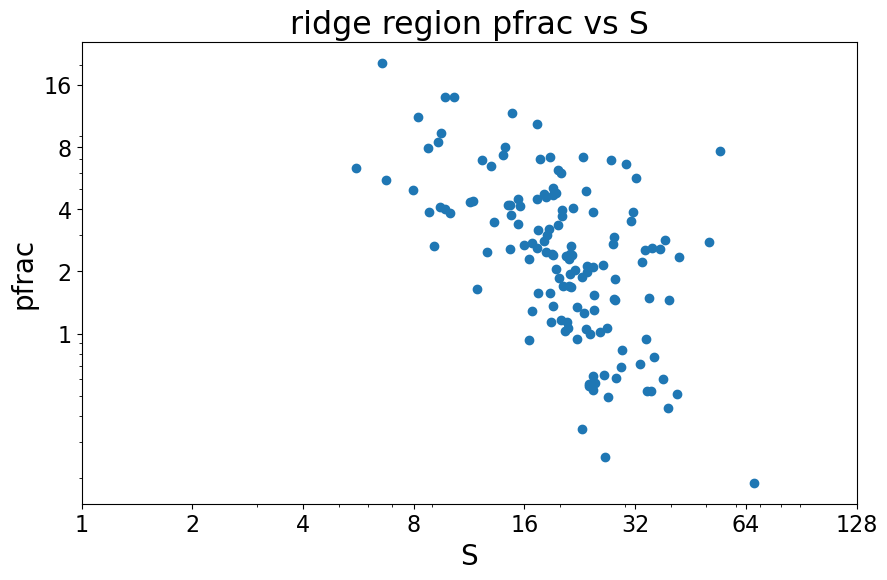

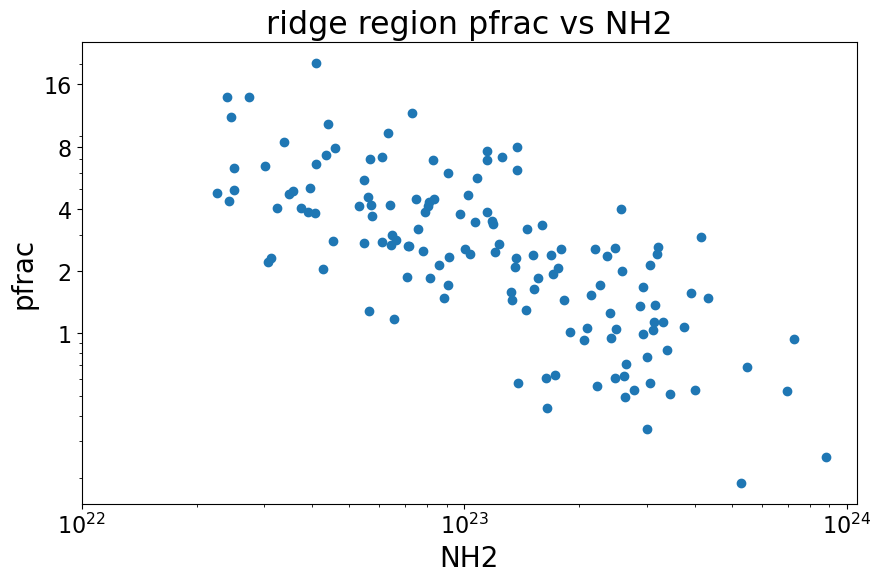

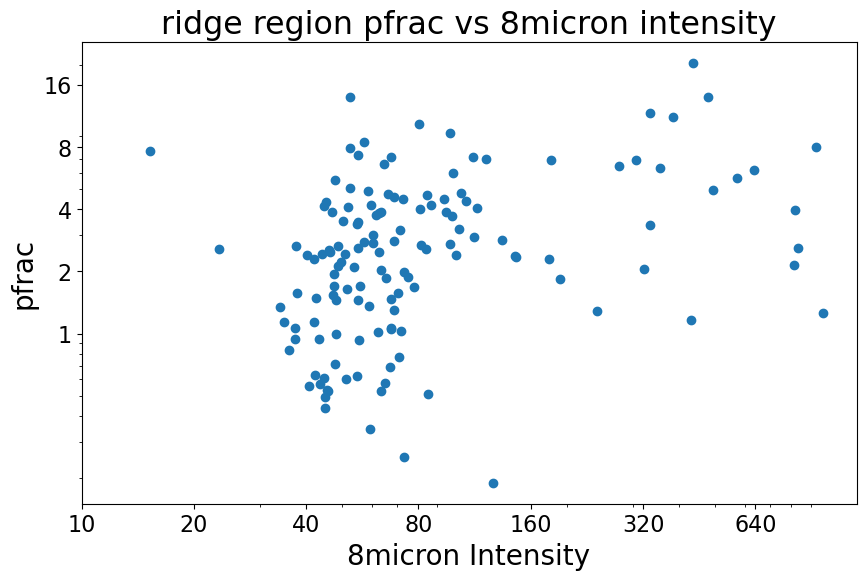

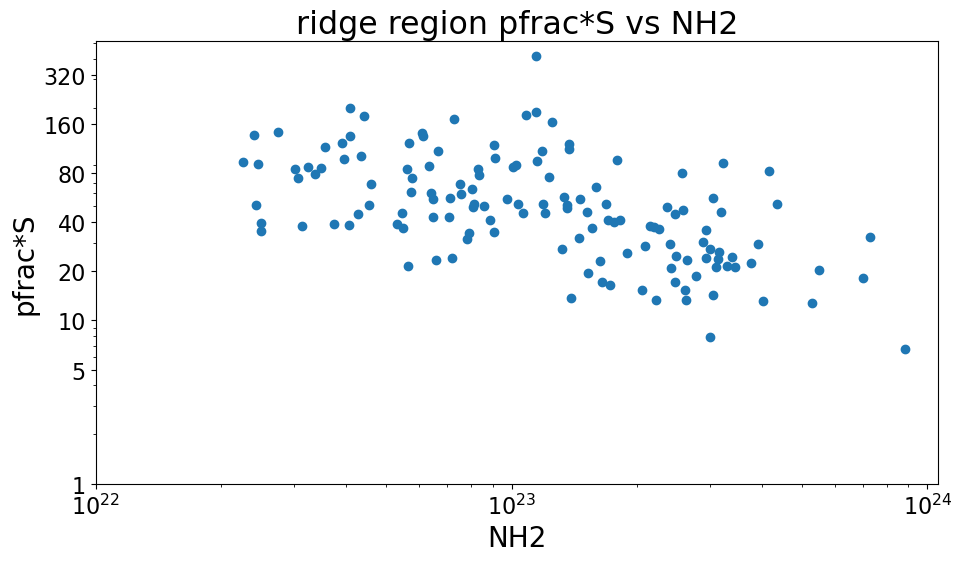

In [53]:
####### changing data to array
s_ridge_array = s_ridge.data.flatten()
p_ridge_array = p_ridge.data.flatten()
I_ridge_array = I_ridge.data.flatten()
nh2_ridge_array = nh2_ridge.data.flatten()
micron8_ridge_array = micron8_ridge.data.flatten()

######## making the data points independent
s_ridge_array_ind = s_ridge_array.copy()
s_ridge_array_ind = s_ridge_array_ind[::4]
p_ridge_array_ind = p_ridge_array.copy()
p_ridge_array_ind = p_ridge_array_ind[::4]
I_ridge_array_ind = I_ridge_array.copy()
I_ridge_array_ind = I_ridge_array_ind[::4]
nh2_ridge_array_ind = nh2_ridge_array.copy()
nh2_ridge_array_ind = nh2_ridge_array_ind[::4]
micron8_ridge_array_ind = micron8_ridge_array.copy()
micron8_ridge_array_ind = micron8_ridge_array_ind[::4]


######### taking log10 of the data
log_s = np.log10(s_ridge_array_ind)
log_p = np.log10(p_ridge_array_ind)
log_I = np.log10(I_ridge_array_ind)
log_nh2 = np.log10(nh2_ridge_array_ind)
log_8micron = np.log10(micron8_ridge_array_ind)


###### making bins for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)


######## Fitting the data 
df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I,'lognh2':log_nh2,'log_8micron':log_8micron})
df_log = df_log.dropna()

####### single parameter fitting
PS_ridge_param, PS_ridge_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc_ridge = lin_fit(s_bins,PS_ridge_param[0],PS_ridge_param[1])
# print(PS_lower_param[0],PS_lower_param[1])

PI_ridge_param, PI_ridge_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc_ridge = lin_fit(I_bins,PI_ridge_param[0],PI_ridge_param[1])
# print(PI_upper_param[0],PI_upper_param[1])

Pnh2_ridge_param, Pnh2_ridge_param_cov = curve_fit(lin_fit, df_log['lognh2'], df_log['logp'])
Pnh2_FitFunc_ridge = lin_fit(nh2_bins,Pnh2_ridge_param[0],Pnh2_ridge_param[1])

###### Double parameter fitting
# p0 = -0.2278,-0.3994,2.
# PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
# print('C :',PSI_param_lower[0])
# print('s index :',PSI_param_lower[1])
# print('I index :',PSI_param_lower[2])

p0 = -0.2278, -0.8567, 2.
PSnh2_param_lower, PSnh2_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']), df_log['logp'],p0)
print('C :',PSnh2_param_lower[0])
print('s index :',PSnh2_param_lower[1])
print('nh2 index :',PSnh2_param_lower[2])


################## plot absolute values
fig = plt.subplots(figsize =(10, 6))
ax1 = plt.subplot(111)
ax1.scatter(s_ridge_array_ind,p_ridge_array_ind)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_ridge_param[1],C = PS_ridge_param[0],linebreak='\n')
# ax1.plot(10**s_bins,10**PS_FitFunc_ridge,'r',linewidth=3,label = label_temp)
ax1.set_title("ridge region pfrac vs S")
ax1.set_ylabel('pfrac',fontdict={'fontsize':20})
ax1.set_xlabel('S',fontdict={'fontsize':20})
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.set_yticks(2**np.array([0,1,2,3,4]))
ax1.set_xticks(2**np.array([0,1,2,3,4,5,6,7]))


# # fig = plt.subplots(figsize =(10, 6))
# # ax2 = plt.subplot(111)
# # ax2.scatter(log_I,log_p)
# # label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_ridge_param[1],C = PI_ridge_param[0],linebreak='\n')
# # ax2.plot(I_bins,PI_FitFunc_ridge,'r',linewidth=3,label = label_temp)
# # ax2.set_ylabel('log p')
# # ax2.set_xlabel('log I')

fig = plt.subplots(figsize =(10, 6))
ax3 = plt.subplot(111)
ax3.scatter(nh2_ridge_array_ind,p_ridge_array_ind)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_ridge_param[1],C = Pnh2_ridge_param[0],linebreak='\n')
# ax3.plot(10**nh2_bins,10**Pnh2_FitFunc_ridge,'r',linewidth=3,label = label_temp)
ax3.set_title("ridge region pfrac vs NH2")
ax3.set_ylabel('pfrac',fontdict={'fontsize':20})
ax3.set_xlabel('NH2',fontdict={'fontsize':20})
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
# ax3.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:0d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax3.set_yticks(2**np.array([0,1,2,3,4]))
ax3.set_xticks(np.array([1e22,1e23,1e24]))

fig = plt.subplots(figsize =(10, 6))
ax4 = plt.subplot(111)
ax4.scatter(micron8_ridge_array_ind,p_ridge_array_ind)
ax4.set_title("ridge region pfrac vs 8micron intensity")
ax4.set_ylabel('pfrac',fontdict={'fontsize':20})
ax4.set_xlabel('8micron Intensity',fontdict={'fontsize':20})
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax4.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax4.set_yticks(2**np.array([0,1,2,3,4]))
ax4.set_xticks(np.array([10,20,40,80,160,320,640]))




fig = plt.subplots(figsize =(10, 6))
ax5 = plt.subplot(111)
ax5.scatter(nh2_ridge_array_ind,p_ridge_array_ind*s_ridge_array_ind)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
ax5.set_title("ridge region pfrac*S vs NH2")
ax5.set_ylabel('pfrac*S',fontdict={'fontsize':20})
ax5.set_xlabel('NH2',fontdict={'fontsize':20})
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax5.set_yticks(np.array([1,5,10,20,40,80,160,320]))
ax5.set_xticks(np.array([1e22,1e23,1e24]))


# ax1.legend()
# ax3.legend()
plt.tight_layout()
plt.rcParams.update({'font.size': 19})
plt.show()



In [13]:
# # ######### plotting the graphs
# fig = plt.subplots(figsize =(10, 6))
# ax1 = plt.subplot(111)
# ax1.scatter(log_s,log_p)
# label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_ridge_param[1],C = PS_ridge_param[0],linebreak='\n')
# ax1.plot(s_bins,PS_FitFunc_ridge,'r',linewidth=3,label = label_temp)
# ax1.set_ylabel('log pfrac ',fontdict={'fontsize':20})
# ax1.set_xlabel('log S ',fontdict={'fontsize':20})


# # fig = plt.subplots(figsize =(10, 6))
# # ax2 = plt.subplot(111)
# # ax2.scatter(log_I,log_p)
# # label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_ridge_param[1],C = PI_ridge_param[0],linebreak='\n')
# # ax2.plot(I_bins,PI_FitFunc_ridge,'r',linewidth=3,label = label_temp)
# # ax2.set_ylabel('log p')
# # ax2.set_xlabel('log I')


# fig = plt.subplots(figsize =(10, 6))
# ax3 = plt.subplot(111)
# ax3.scatter(log_nh2,log_p)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_ridge_param[1],C = Pnh2_ridge_param[0],linebreak='\n')
# ax3.plot(nh2_bins,Pnh2_FitFunc_ridge,'r',linewidth=3,label = label_temp)
# ax3.set_ylabel('log pfrac',fontdict={'fontsize':20})
# ax3.set_xlabel('log Column Density',fontdict={'fontsize':20})


# fig = plt.subplots(figsize =(10, 6))
# ax4 = plt.subplot(111)
# ax4.scatter(log_8micron,log_p)
# ax4.set_ylabel('log pfrac',fontdict={'fontsize':20})
# ax4.set_xlabel('log 8micron Intensity',fontdict={'fontsize':20})


# fig = plt.subplots(figsize =(10, 6))
# ax5 = plt.subplot(111)
# ax5.scatter(np.log10(nh2_ridge_array_ind),np.log10(p_ridge_array_ind*s_ridge_array_ind))
# # label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
# # ax4.set_title("whole region log pfrac vs log 8micron intensity")
# ax5.set_ylabel('log pfrac*S',fontdict={'fontsize':20})
# ax5.set_xlabel('log Column density',fontdict={'fontsize':20})


# ax1.legend()
# ax3.legend()
# plt.tight_layout()
# plt.show()


binned data analysis ridge region 

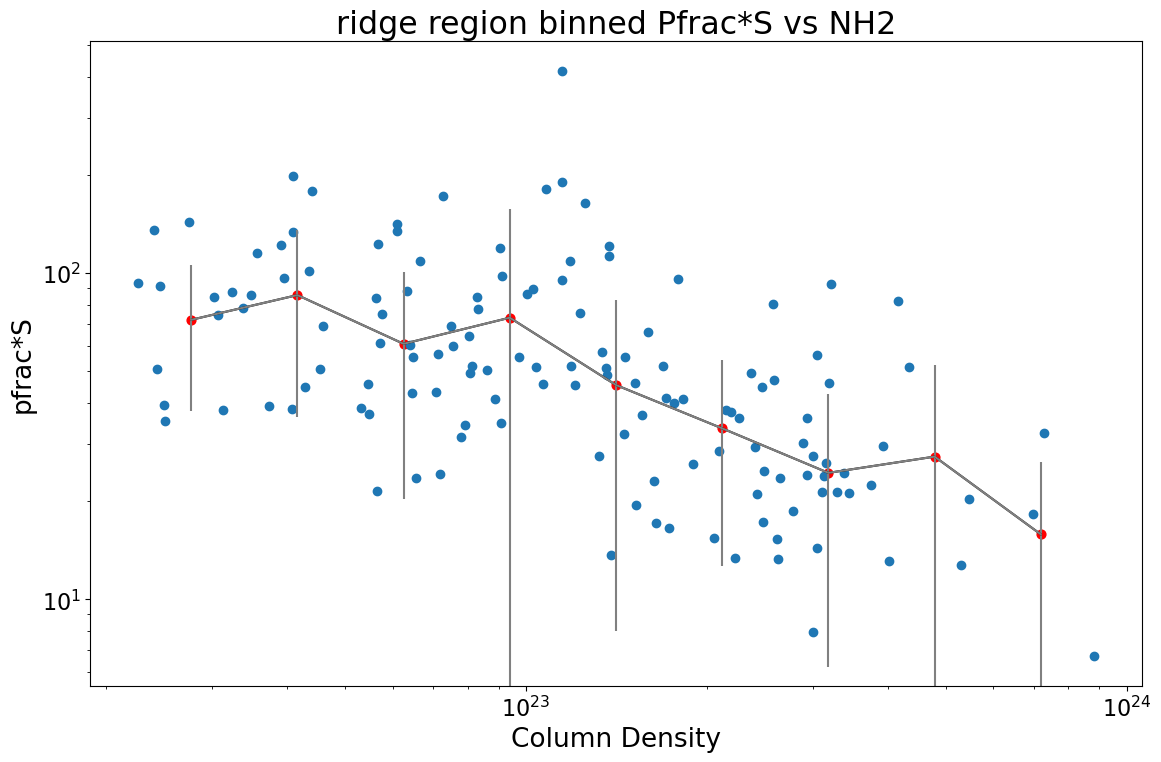

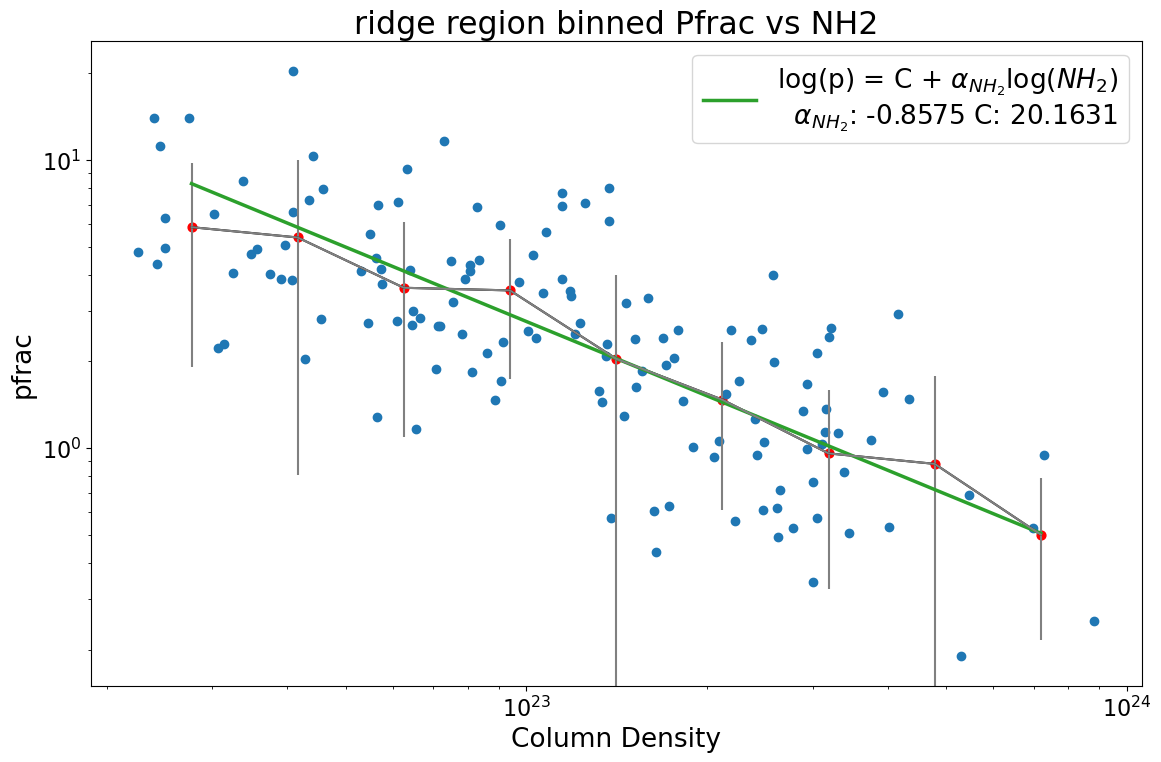

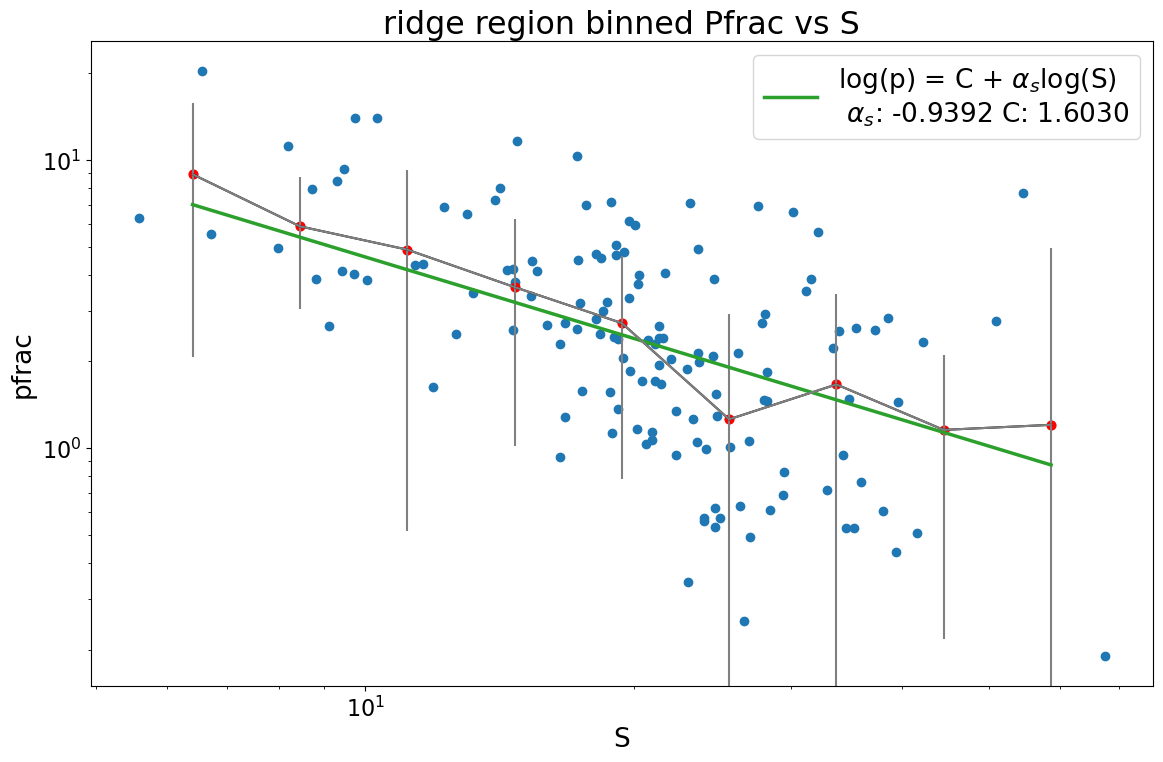

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


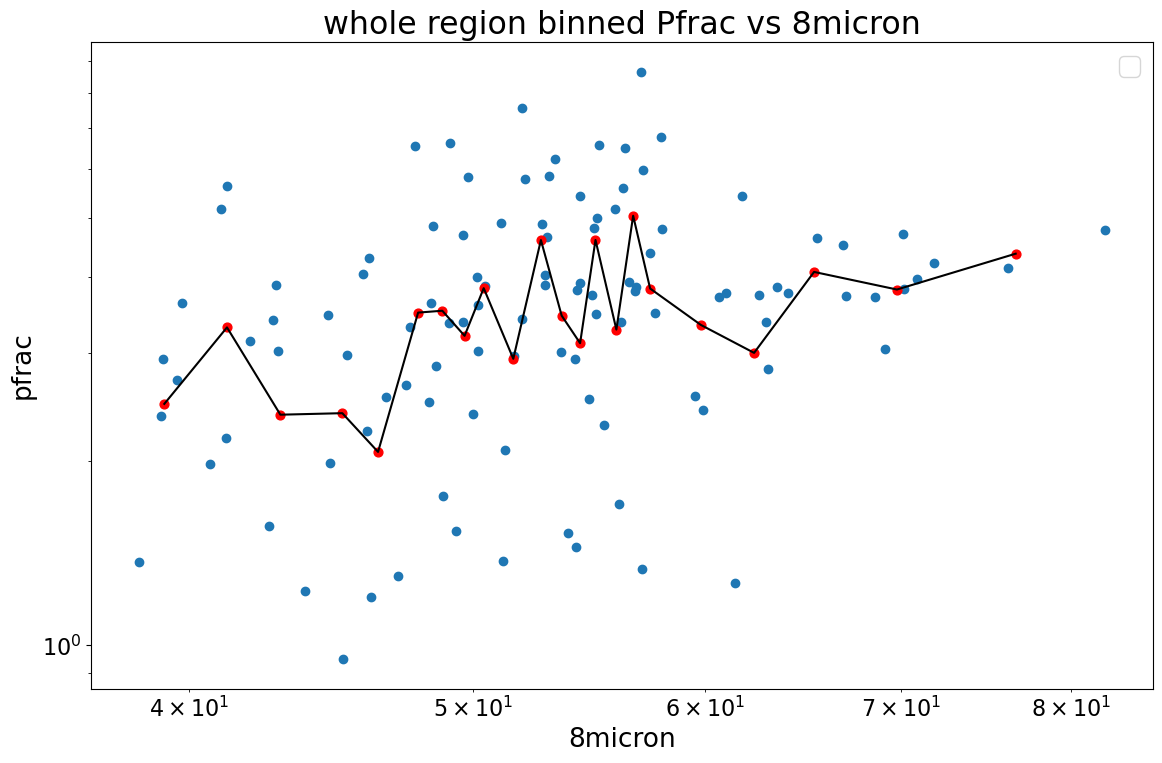

In [58]:
plt.figure(figsize=(12,8))
binning_datav2(np.log10(nh2_ridge_array_ind),np.log10(p_ridge_array_ind*s_ridge_array_ind),10)
plt.scatter(nh2_ridge_array_ind,p_ridge_array_ind*s_ridge_array_ind)
plt.title('ridge region binned Pfrac*S vs NH2')
plt.xlabel('Column Density')
plt.ylabel('pfrac*S')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,8))
binning_datav2(np.log10(nh2_ridge_array_ind),np.log10(p_ridge_array_ind),10)
plt.scatter(nh2_ridge_array_ind,p_ridge_array_ind)
param,x,y = binning_datav3(np.log10(nh2_ridge_array_ind),np.log10(p_ridge_array_ind),10)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('ridge region binned Pfrac vs NH2')
plt.xlabel('Column Density')
plt.ylabel('pfrac')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(s_ridge_array_ind,p_ridge_array_ind)
binning_datav2(np.log10(s_ridge_array_ind),np.log10(p_ridge_array_ind),10)
param,x,y = binning_datav3(np.log10(s_ridge_array_ind),np.log10(p_ridge_array_ind),10)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('ridge region binned Pfrac vs S')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()
plt.show()

log_p = np.array(df_log['logp'])
log_8micron = np.array(df_log['log_8micron'])

plt.figure(figsize=(12,8))
plt.scatter(10**log_8micron,10**log_p)
binning_equal(log_8micron,log_p,20)
plt.title('whole region binned Pfrac vs 8micron')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('8micron')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()
plt.show()



Bootstrap error Ridge region

In [15]:
s_ridge_array = s_ridge.data.flatten()
p_ridge_array = p_ridge.data.flatten()
nh2_ridge_array = nh2_ridge.data.flatten()

log_s = np.log(s_ridge_array)
log_p = np.log(p_ridge_array)
log_nh2 = np.log(nh2_ridge_array)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()
bootarr = np.array(df_log)

bootresult = bootstrap(bootarr,10000,bootfunc=curve_fitting)
print('error in alpha_s',np.std(bootresult[:,1]))
print('error in alpha_nh2',np.std(bootresult[:,2]))

error in alpha_s 0.03282505552614467
error in alpha_nh2 0.07311804933216819


Analysis of the Sub-filament region

C : 8.492522244889987
s index : -0.2609739200206022
nh2 index : -0.34053704154807235


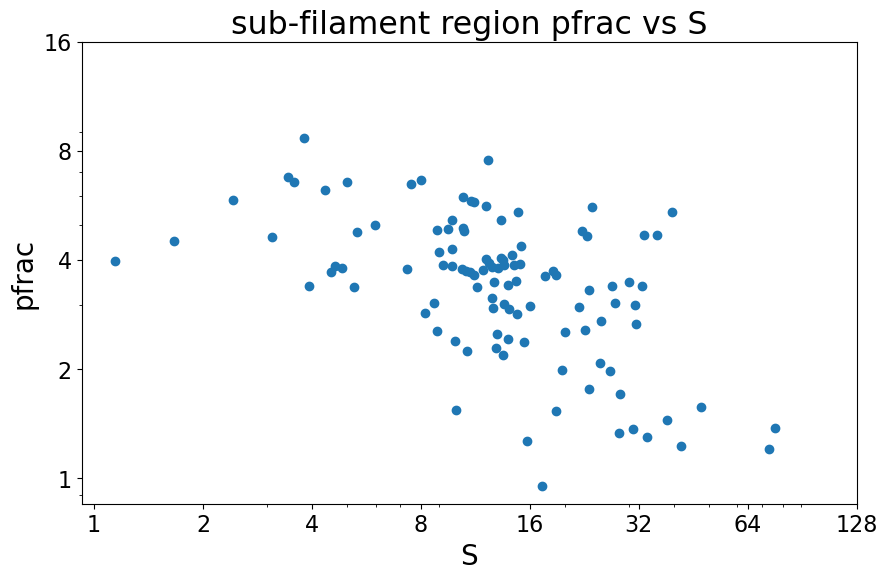

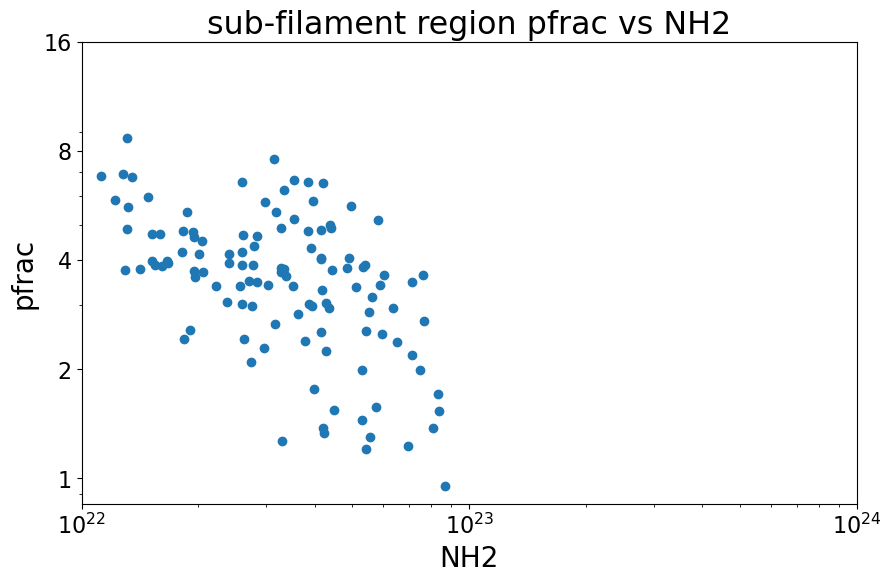

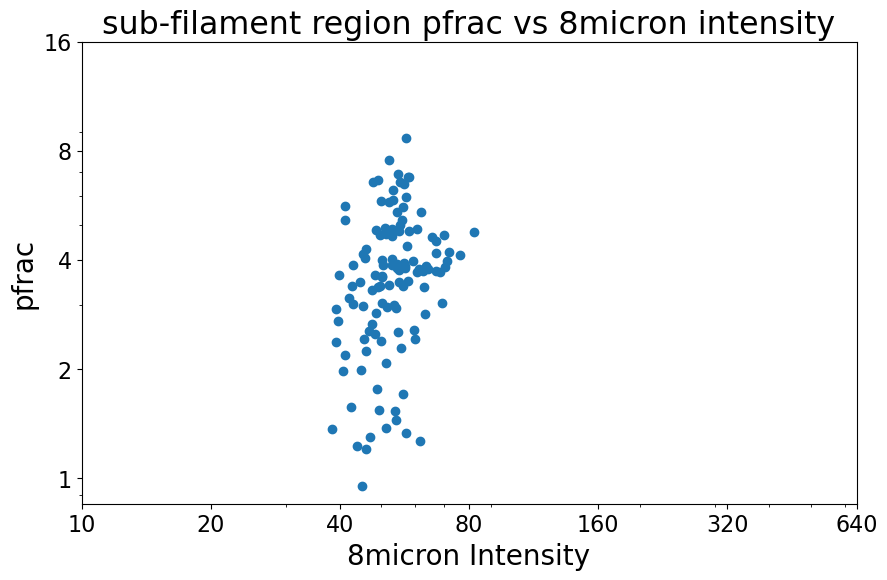

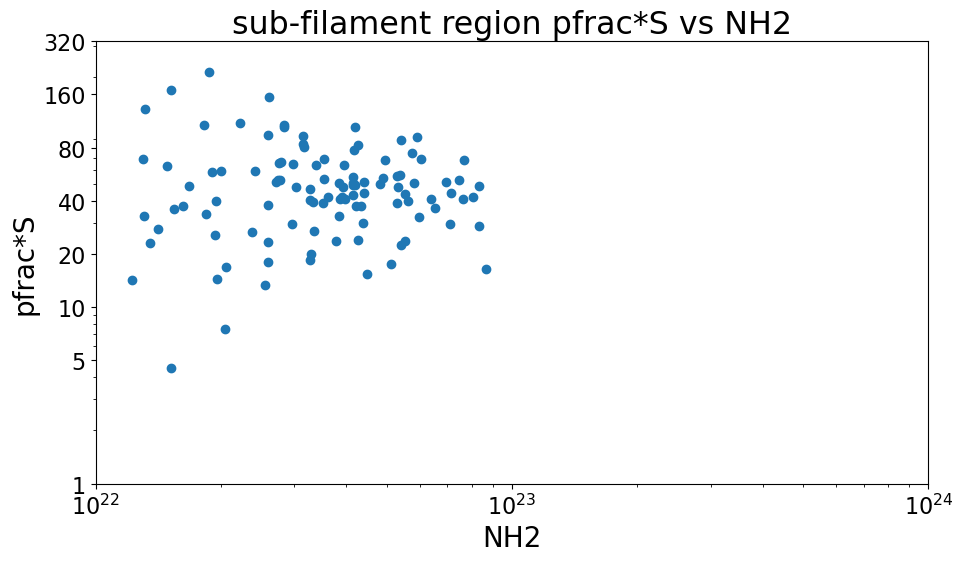

In [59]:
####### changing data to array
s_fil_right_array = s_fil_right.data.flatten()
p_fil_right_array = p_fil_right.data.flatten()
I_fil_right_array = I_fil_right.data.flatten()
nh2_fil_right_array = nh2_fil_right.data.flatten()
micron8_fil_right_array = micron8_fil_right.data.flatten()


######## making the data points independent
s_fil_right_array_ind = s_fil_right_array.copy()
s_fil_right_array_ind = s_fil_right_array_ind[::4]
p_fil_right_array_ind = p_fil_right_array.copy()
p_fil_right_array_ind = p_fil_right_array_ind[::4]
I_fil_right_array_ind = I_fil_right_array.copy()
I_fil_right_array_ind = I_fil_right_array_ind[::4]
nh2_fil_right_array_ind = nh2_fil_right_array.copy()
nh2_fil_right_array_ind = nh2_fil_right_array_ind[::4]
micron8_fil_right_array_ind = micron8_fil_right_array.copy()
micron8_fil_right_array_ind = micron8_fil_right_array_ind[::4]


######## taking log10 of the data
log_s_fil = np.log10(s_fil_right_array_ind)
log_p_fil = np.log10(p_fil_right_array_ind)
log_I_fil = np.log10(I_fil_right_array_ind)
log_nh2_fil = np.log10(nh2_fil_right_array_ind)
log_8micron_fil = np.log10(micron8_fil_right_array_ind)


###### making bins for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
micron8_min = np.nanmin(log_8micron)
micron8_max = np.nanmax(log_8micron)  

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)
micron8_bins = np.linspace(micron8_min,micron8_max,100)


######## curve fitting
df_log = pd.DataFrame({'logp': log_p_fil,'logs':log_s_fil,'logI':log_I_fil,'lognh2':log_nh2_fil,'log_8micron':log_8micron_fil})
df_log = df_log.dropna()

###### single parameter fitting
PS_fil_right_param, PS_fil_right_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc_fil_right = lin_fit(s_bins,PS_fil_right_param[0],PS_fil_right_param[1])
# print(PS_lower_param[0],PS_lower_param[1])

PI_fil_right_param, PI_fil_right_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc_fil_right = lin_fit(I_bins,PI_fil_right_param[0],PI_fil_right_param[1])
# print(PI_upper_param[0],PI_upper_param[1])

Pnh2_fil_right_param, Pnh2_fil_right_param_cov = curve_fit(lin_fit, df_log['lognh2'], df_log['logp'])
Pnh2_FitFunc_fil_right = lin_fit(nh2_bins,Pnh2_fil_right_param[0],Pnh2_fil_right_param[1])


##### Double parameter fitting
# p0 = -0.2278,-0.3994,2.
# PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
# print('C :',PSI_param_lower[0])
# print('s index :',PSI_param_lower[1])
# print('I index :',PSI_param_lower[2])

p0 = -0.2278, -0.8567, 2.
PSNH2_param_lower, PSNH2_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']), df_log['logp'],p0)
print('C :',PSNH2_param_lower[0])
print('s index :',PSNH2_param_lower[1])
print('nh2 index :',PSNH2_param_lower[2])



################## plot absolute values

fig = plt.subplots(figsize =(10, 6))
ax1 = plt.subplot(111)
ax1.scatter(s_fil_right_array_ind,p_fil_right_array_ind)
# label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_fil_right_param[1],C = PS_fil_right_param[0],linebreak='\n')
# ax1.plot(10**s_bins,10**PS_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
ax1.set_title("sub-filament region pfrac vs S")
ax1.set_ylabel('pfrac',fontdict={'fontsize':20})
ax1.set_xlabel('S',fontdict={'fontsize':20})
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.set_yticks(2**np.array([0,1,2,3,4]))
ax1.set_xticks(2**np.array([0,1,2,3,4,5,6,7]))



# fig = plt.subplots(figsize =(10, 6))
# ax2 = plt.subplot(111)
# ax2.scatter(log_I,log_p)
# label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_fil_right_param[1],C = PI_fil_right_param[0],linebreak='\n')
# ax2.plot(I_bins,PI_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
# ax2.set_ylabel('log p')
# ax2.set_xlabel('log I')
  

fig = plt.subplots(figsize =(10, 6))
ax3 = plt.subplot(111)
ax3.scatter(nh2_fil_right_array_ind,p_fil_right_array_ind)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_fil_right_param[1],C = Pnh2_fil_right_param[0],linebreak='\n')
# ax3.plot(10**nh2_bins,10**Pnh2_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
ax3.set_title("sub-filament region pfrac vs NH2")
ax3.set_ylabel('pfrac',fontdict={'fontsize':20})
ax3.set_xlabel('NH2',fontdict={'fontsize':20})
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
# ax3.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:0d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax3.set_yticks(2**np.array([0,1,2,3,4]))
ax3.set_xticks(np.array([1e22,1e23,1e24]))

fig = plt.subplots(figsize =(10, 6))
ax4 = plt.subplot(111)
ax4.scatter(micron8_fil_right_array_ind,p_fil_right_array_ind)
ax4.set_title("sub-filament region pfrac vs 8micron intensity")
ax4.set_ylabel('pfrac',fontdict={'fontsize':20})
ax4.set_xlabel('8micron Intensity',fontdict={'fontsize':20})
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax4.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax4.set_yticks(2**np.array([0,1,2,3,4]))
ax4.set_xticks(np.array([10,20,40,80,160,320,640]))


fig = plt.subplots(figsize =(10, 6))
ax5 = plt.subplot(111)
ax5.scatter(nh2_fil_right_array_ind,p_fil_right_array_ind*s_fil_right_array_ind)
ax5.set_title("sub-filament region pfrac*S vs NH2")
ax5.set_ylabel('pfrac*S',fontdict={'fontsize':20})
ax5.set_xlabel('NH2',fontdict={'fontsize':20})
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax5.set_yticks(np.array([1,5,10,20,40,80,160,320]))
ax5.set_xticks(np.array([1e22,1e23,1e24]))


# ax1.legend()
# ax3.legend()
plt.tight_layout()
plt.rcParams.update({'font.size': 19})
plt.show()



In [17]:
########## plotting the graphs
# fig = plt.subplots(figsize =(10, 6))
# ax1 = plt.subplot(111)
# ax1.scatter(log_s,log_p)
# label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_fil_right_param[1],C = PS_fil_right_param[0],linebreak='\n')
# ax1.plot(s_bins,PS_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
# ax1.set_ylabel('log pfrac ',fontdict={'fontsize':20})
# ax1.set_xlabel('log S ',fontdict={'fontsize':20})


# # # fig = plt.subplots(figsize =(10, 6))
# # # ax2 = plt.subplot(111)
# # # ax2.scatter(log_I,log_p)
# # # label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_fil_right_param[1],C = PI_fil_right_param[0],linebreak='\n')
# # # ax2.plot(I_bins,PI_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
# # # ax2.set_ylabel('log p')
# # # ax2.set_xlabel('log I')


# fig = plt.subplots(figsize =(10, 6))
# ax3 = plt.subplot(111)
# ax3.scatter(log_nh2,log_p)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_fil_right_param[1],C = Pnh2_fil_right_param[0],linebreak='\n')
# ax3.plot(nh2_bins,Pnh2_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
# ax3.set_ylabel('log pfrac',fontdict={'fontsize':20})
# ax3.set_xlabel('log Column Density',fontdict={'fontsize':20})


# fig = plt.subplots(figsize =(10, 6))
# ax4 = plt.subplot(111)
# ax4.scatter(log_8micron,log_p)
# ax4.set_ylabel('log pfrac',fontdict={'fontsize':20})
# ax4.set_xlabel('log 8micron Intensity',fontdict={'fontsize':20})


# fig = plt.subplots(figsize =(10, 6))
# ax5 = plt.subplot(111)
# ax5.scatter(np.log10(nh2_fil_right_array_ind),np.log10(p_fil_right_array_ind*s_fil_right_array_ind))
# ax5.set_ylabel('log pfrac*S',fontdict={'fontsize':20})
# ax5.set_xlabel('log Column density',fontdict={'fontsize':20})



# ax1.legend()
# ax3.legend()
# plt.legend()
# plt.tight_layout()
# plt.show()


binned data analysis sub-filament region 

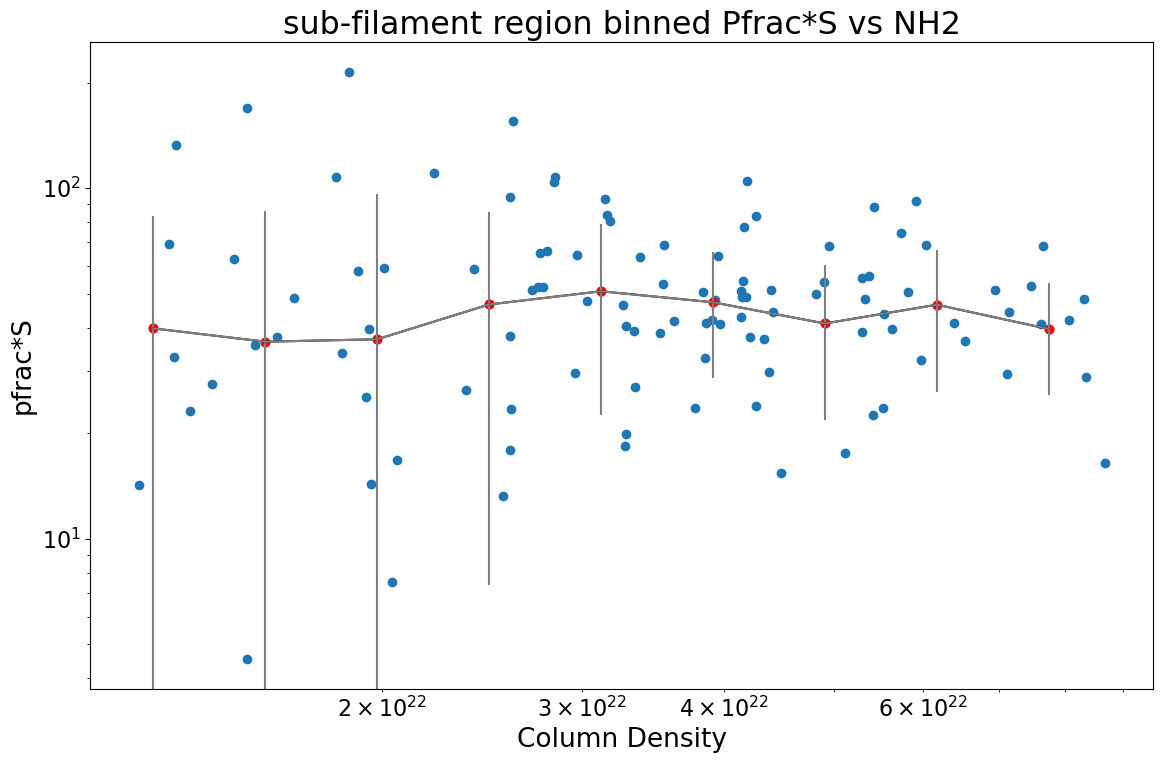

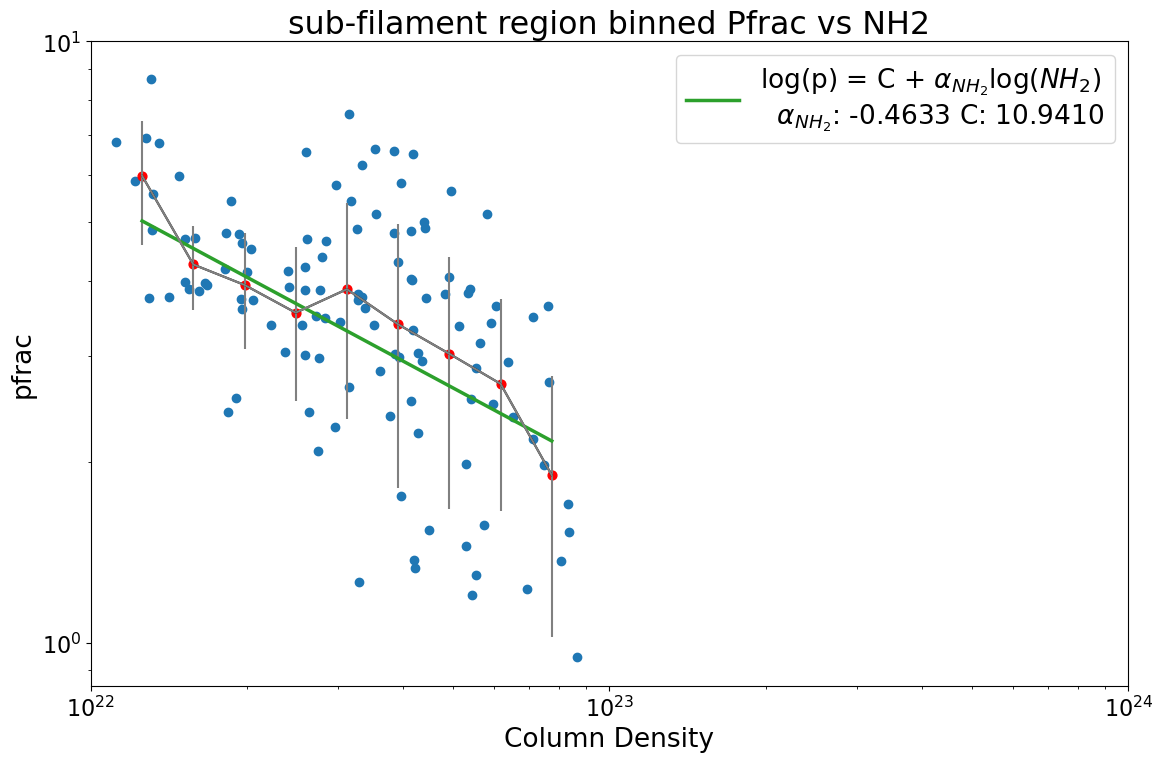

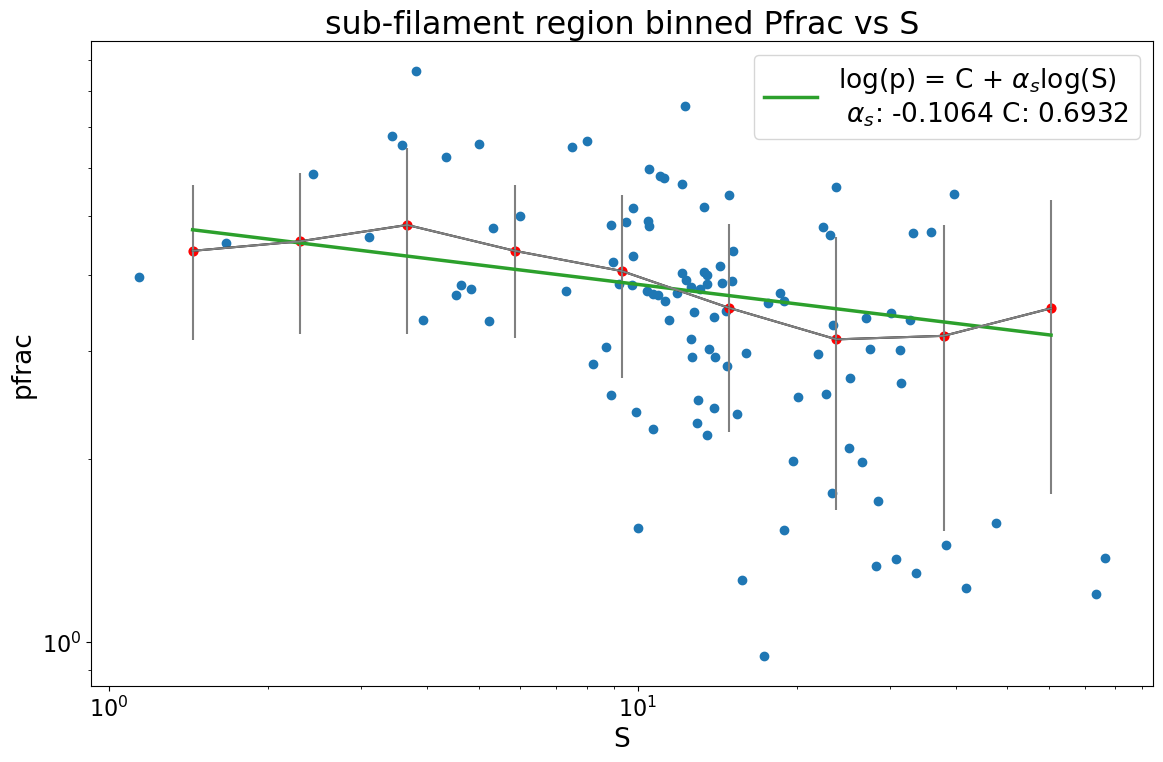

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


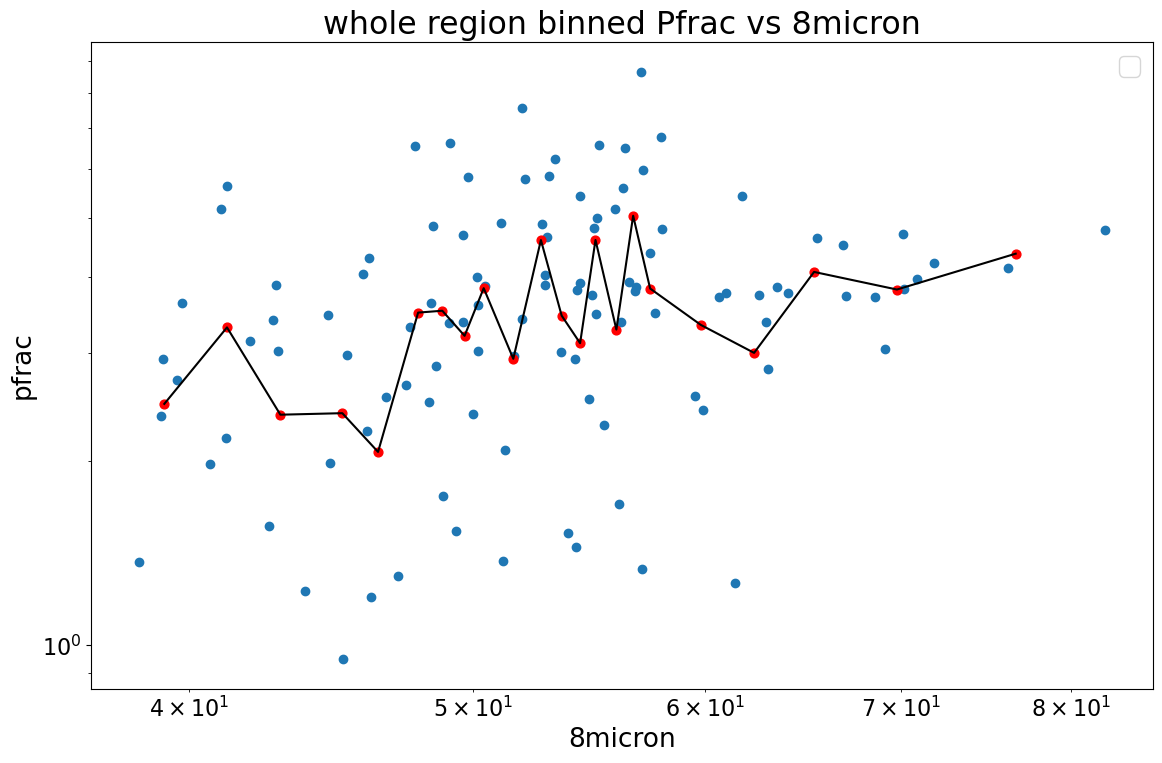

In [60]:
######## binning data

plt.figure(figsize=(12,8))
plt.scatter(nh2_fil_right_array_ind,p_fil_right_array_ind*s_fil_right_array_ind)
binning_datav2(np.log10(nh2_fil_right_array_ind),np.log10(p_fil_right_array_ind*s_fil_right_array_ind),10)
plt.title('sub-filament region binned Pfrac*S vs NH2')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Column Density')
plt.ylabel('pfrac*S')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(nh2_fil_right_array_ind,p_fil_right_array_ind)
binning_datav2(np.log10(nh2_fil_right_array_ind),np.log10(p_fil_right_array_ind),10)
param,x,y = binning_datav3(np.log10(nh2_fil_right_array_ind),np.log10(p_fil_right_array_ind),10)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('sub-filament region binned Pfrac vs NH2')
plt.xscale('log')
plt.yscale('log')
plt.yticks([1e0,1e1])
plt.xticks(np.array([1e22,1e23,1e24]))
plt.xlabel('Column Density')
plt.ylabel('pfrac')
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12,8))
plt.scatter(s_fil_right_array_ind,p_fil_right_array_ind)
binning_datav2(np.log10(s_fil_right_array_ind),np.log10(p_fil_right_array_ind),10)
param,x,y = binning_datav3(np.log10(s_fil_right_array_ind),np.log10(p_fil_right_array_ind),10)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('sub-filament region binned Pfrac vs S')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()
plt.show()

log_p = np.array(df_log['logp'])
log_8micron = np.array(df_log['log_8micron'])
plt.figure(figsize=(12,8))
plt.scatter(10**log_8micron,10**log_p)
binning_equal(log_8micron,log_p,20)
plt.title('whole region binned Pfrac vs 8micron')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('8micron')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()
plt.show()

Bootstrap error Sub-filament region.

In [19]:
s_fil_right_array = s_fil_right.data.flatten()
p_fil_right_array = p_fil_right.data.flatten()
nh2_fil_right_array = nh2_fil_right.data.flatten()

log_s = np.log(s_fil_right_array)
log_p = np.log(p_fil_right_array)
log_nh2 = np.log(nh2_fil_right_array)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()
bootarr = np.array(df_log)

bootresult = bootstrap(bootarr,10000,bootfunc=curve_fitting)
print('error in alpha_s',np.std(bootresult[:,1]))
print('error in alpha_nh2',np.std(bootresult[:,2]))

error in alpha_s 0.0348429525062929
error in alpha_nh2 0.0317632578197879


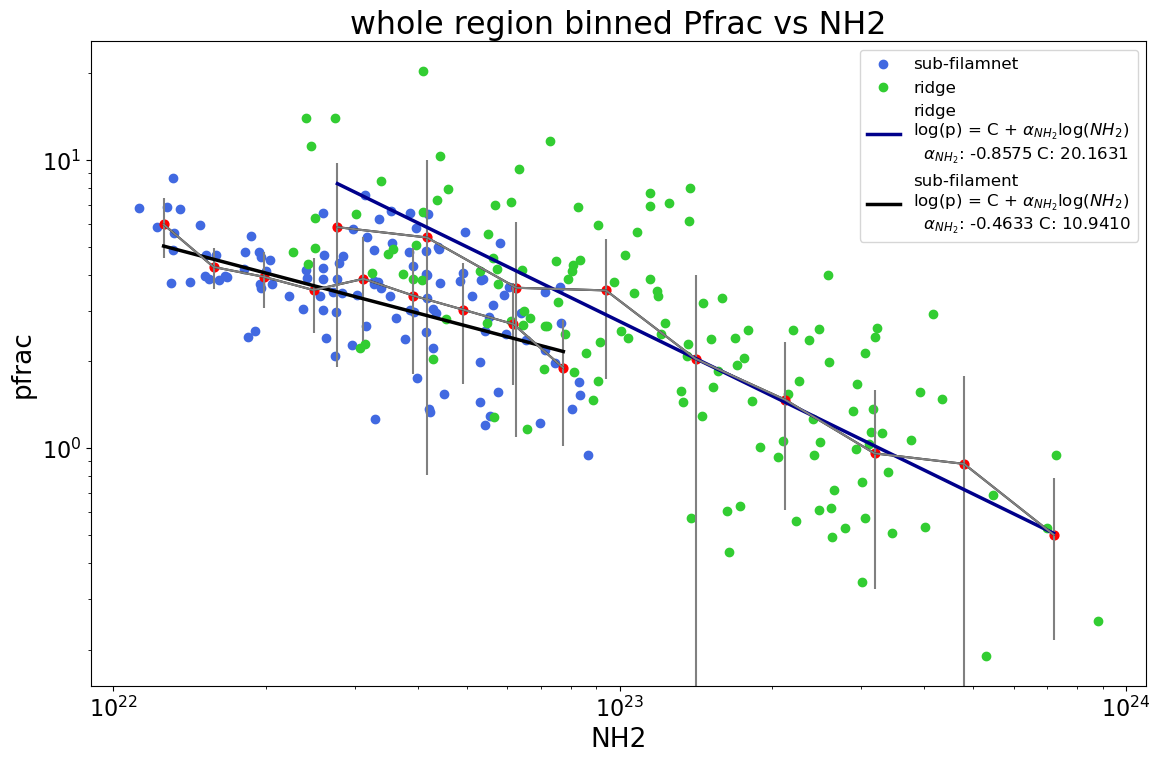

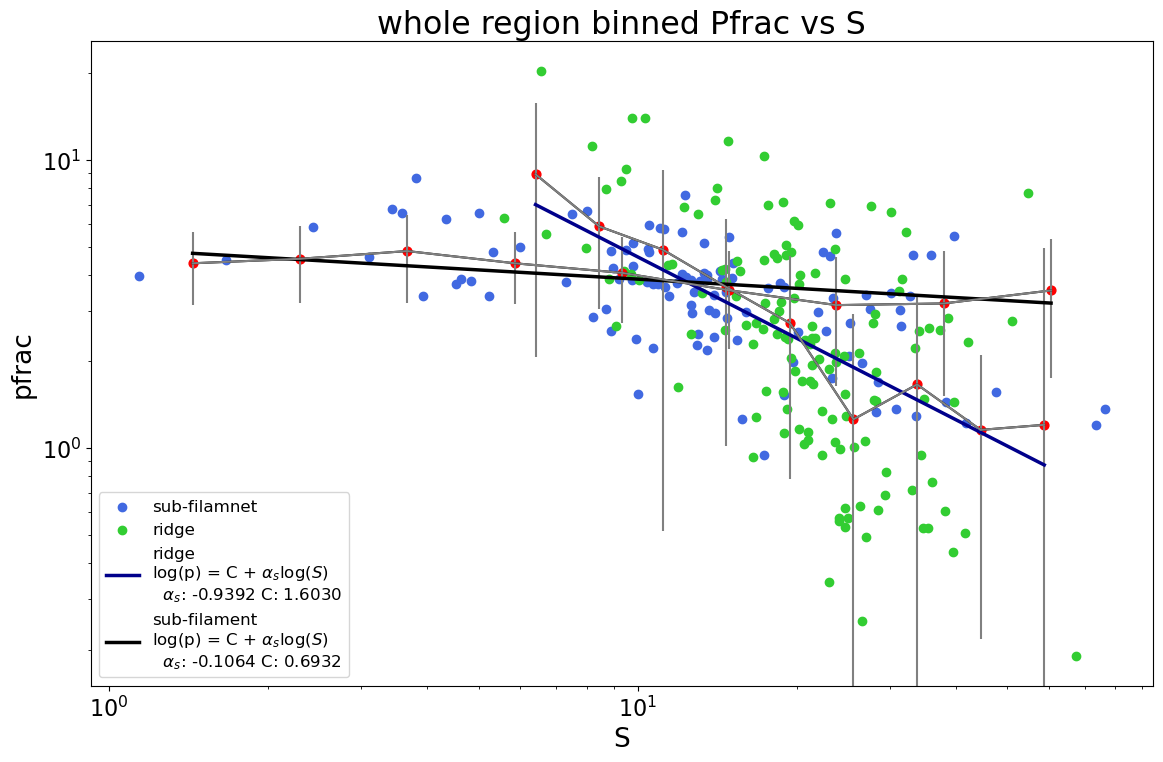

In [20]:
plt.figure(figsize=(12,8))
plt.scatter(nh2_fil_right_array_ind,p_fil_right_array_ind,c = 'royalblue',label = 'sub-filamnet')
plt.scatter(nh2_ridge_array_ind,p_ridge_array_ind,c='limegreen',label = 'ridge')
binning_datav2(np.log10(nh2_fil_right_array_ind),np.log10(p_fil_right_array_ind),10)
binning_datav2(np.log10(nh2_ridge_array_ind),np.log10(p_ridge_array_ind),10)
param,x,y = binning_datav3(np.log10(nh2_ridge_array_ind),np.log10(p_ridge_array_ind),10)
label_temp = r'ridge{linebreak}log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'darkblue',linewidth = 2.5,label = label_temp)
param,x,y = binning_datav3(np.log10(nh2_fil_right_array_ind),np.log10(p_fil_right_array_ind),10)
label_temp = r'sub-filament{linebreak}log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'k',linewidth = 2.5,label = label_temp)
plt.title('whole region binned Pfrac vs NH2')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('NH2')
plt.ylabel('pfrac')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(s_fil_right_array_ind,p_fil_right_array_ind,c = 'royalblue',label = 'sub-filamnet')
plt.scatter(s_ridge_array_ind,p_ridge_array_ind,c='limegreen',label = 'ridge')
binning_datav2(np.log10(s_fil_right_array_ind),np.log10(p_fil_right_array_ind),10)
binning_datav2(np.log10(s_ridge_array_ind),np.log10(p_ridge_array_ind),10)
param,x,y = binning_datav3(np.log10(s_ridge_array_ind),np.log10(p_ridge_array_ind),10)
label_temp = r'ridge{linebreak}log(p) = C + $\alpha_s$log($S$){linebreak}  $\alpha_s$: {alpha_s:.4f} C: {C:.4f}'.format(alpha_s = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'darkblue',linewidth = 2.5,label = label_temp)
param,x,y = binning_datav3(np.log10(s_fil_right_array_ind),np.log10(p_fil_right_array_ind),10)
label_temp = r'sub-filament{linebreak}log(p) = C + $\alpha_s$log($S$){linebreak}  $\alpha_s$: {alpha_s:.4f} C: {C:.4f}'.format(alpha_s = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'k',linewidth = 2.5,label = label_temp)
plt.title('whole region binned Pfrac vs S')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S')
plt.ylabel('pfrac')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


Analysis of the outflow region

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


C : -14.324875508253614
s index : -0.21906368536367482
nh2 index : 0.6827129564210055


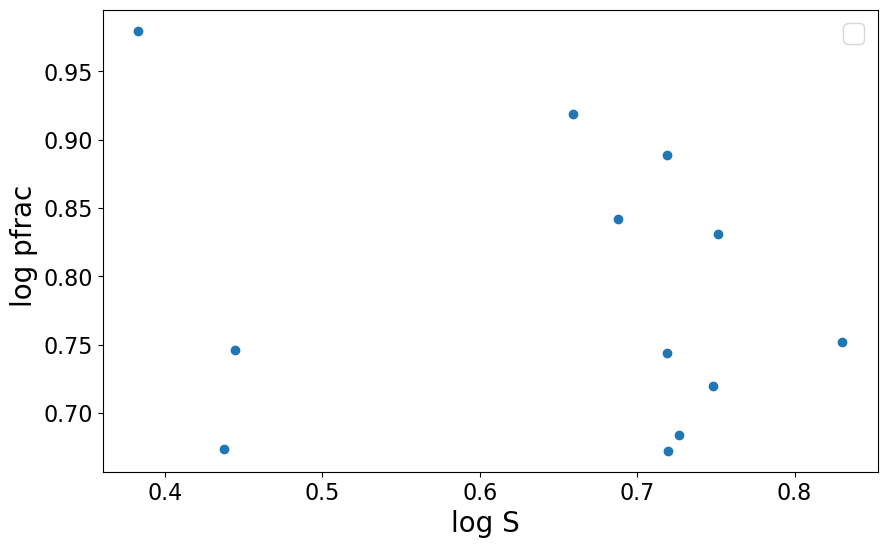

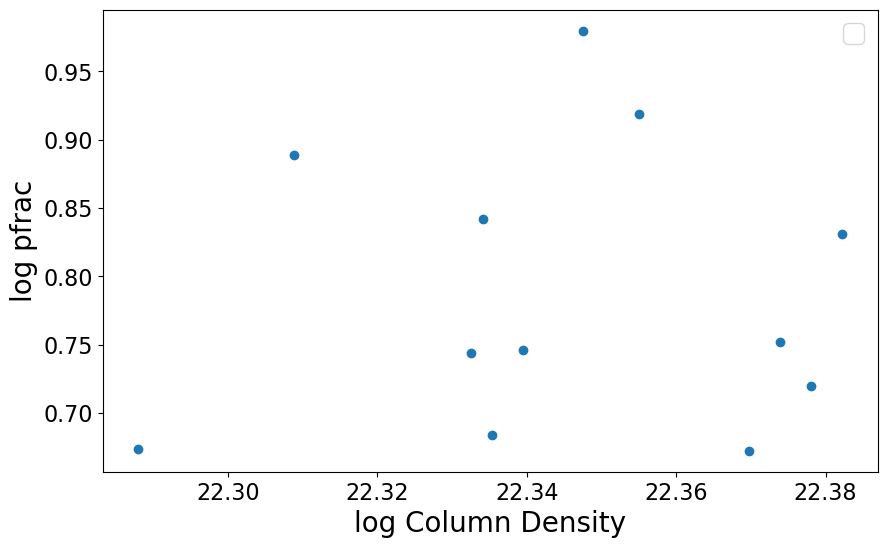

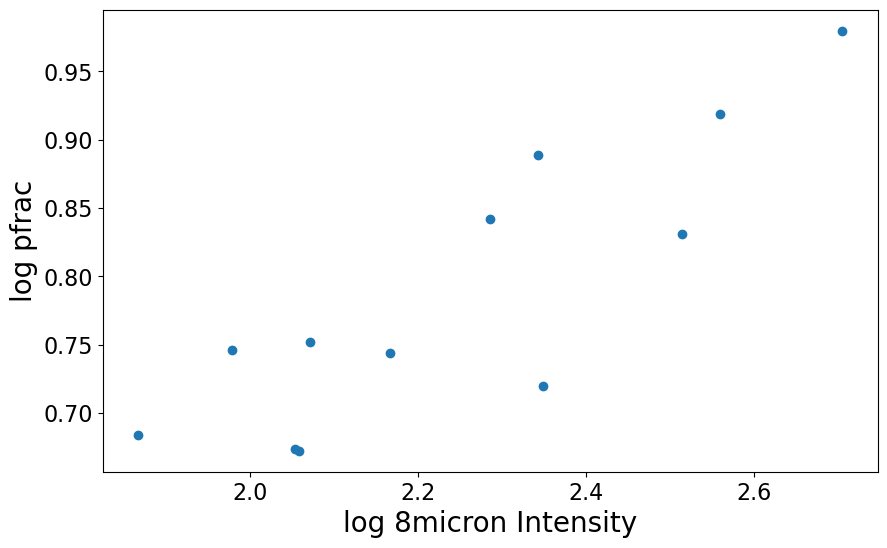

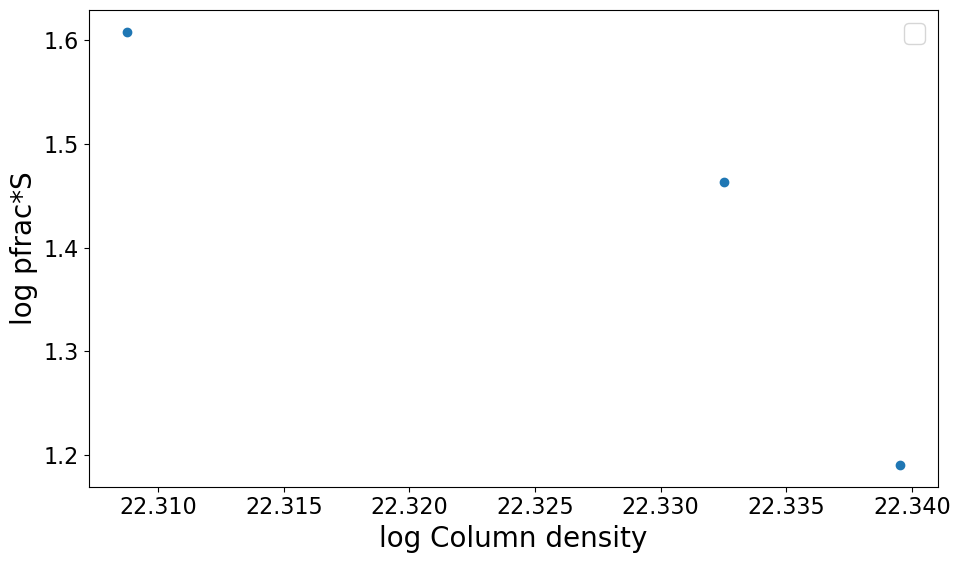

In [21]:
######## changing data to array
s_outflow_array = s_outflow.data.flatten()
p_outflow_array = p_outflow.data.flatten()
I_outflow_array = I_outflow.data.flatten()
nh2_outflow_array = nh2_outflow.data.flatten()
micron8_outflow_array = micron8_outflow.data.flatten()

s_outflow_array_ind = s_outflow_array.copy()
s_outflow_array_ind = s_outflow_array_ind[::4]
p_outflow_array_ind = p_outflow_array.copy()
p_outflow_array_ind = p_outflow_array_ind[::4]
I_outflow_array_ind = I_outflow_array.copy()
I_outflow_array_ind = I_outflow_array_ind[::4]
nh2_outflow_array_ind = nh2_outflow_array.copy()
nh2_outflow_array_ind = nh2_outflow_array_ind[::4]
micron8_outflow_array_ind = micron8_outflow_array.copy()
micron8_outflow_array_ind = micron8_outflow_array_ind[::4]


####### taking log10 of the data
log_s = np.log10(s_outflow_array)
log_p = np.log10(p_outflow_array)
log_I = np.log10(I_outflow_array)
log_nh2 = np.log10(nh2_outflow_array)
log_8micron = np.log10(micron8_outflow_array)


###### making bins for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
micron8_min = np.nanmin(log_8micron)
micron8_max = np.nanmax(log_8micron)  

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)
micron8_bins = np.linspace(micron8_min,micron8_max,100)


######## fitting the data
df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I,'lognh2':log_nh2,'log_8micron':log_8micron})
df_log = df_log.dropna()

###### single parameter fitting
PS_outflow_param, PS_outflow_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc_outflow = lin_fit(s_bins,PS_outflow_param[0],PS_outflow_param[1])
# print(PS_lower_param[0],PS_lower_param[1])

PI_outflow_param, PI_outflow_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc_outflow = lin_fit(I_bins,PI_outflow_param[0],PI_outflow_param[1])
# print(PI_upper_param[0],PI_upper_param[1])

Pnh2_outflow_param, Pnh2_outflow_param_cov = curve_fit(lin_fit, df_log['lognh2'], df_log['logp'])
Pnh2_FitFunc_outflow = lin_fit(nh2_bins,Pnh2_outflow_param[0],Pnh2_outflow_param[1])


###### double parameter fitting
# p0 = -0.2278,-0.3994,2.
# PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
# print('C :',PSI_param_lower[0])
# print('s index :',PSI_param_lower[1])
# print('I index :',PSI_param_lower[2])

p0 = -0.2278, -0.8567, 2.
PSNH2_param_lower, PSNH2_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']), df_log['logp'],p0)
print('C :',PSNH2_param_lower[0])
print('s index :',PSNH2_param_lower[1])
print('nh2 index :',PSNH2_param_lower[2])


######### plotting the graphs
fig = plt.subplots(figsize =(10, 6))
ax1 = plt.subplot(111)
ax1.scatter(log_s,log_p)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_outflow_param[1],C = PS_outflow_param[0],linebreak='\n')
# ax1.plot(s_bins,PS_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
ax1.set_ylabel('log pfrac ',fontdict={'fontsize':20})
ax1.set_xlabel('log S ',fontdict={'fontsize':20})


# fig = plt.subplots(figsize =(10, 6))
# ax2 = plt.subplot(111)
# ax2.scatter(log_I,log_p)
# label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_fil_right_param[1],C = PI_fil_right_param[0],linebreak='\n')
# ax2.plot(I_bins,PI_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
# ax2.set_ylabel('log p')
# ax2.set_xlabel('log I')


fig = plt.subplots(figsize =(10, 6))
ax3 = plt.subplot(111)
ax3.scatter(log_nh2,log_p)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_outflow_param[1],C = Pnh2_outflow_param[0],linebreak='\n')
# ax3.plot(nh2_bins,Pnh2_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
ax3.set_ylabel('log pfrac',fontdict={'fontsize':20})
ax3.set_xlabel('log Column Density',fontdict={'fontsize':20})


fig = plt.subplots(figsize =(10, 6))
ax4 = plt.subplot(111)
ax4.scatter(log_8micron,log_p)
ax4.set_ylabel('log pfrac',fontdict={'fontsize':20})
ax4.set_xlabel('log 8micron Intensity',fontdict={'fontsize':20})


fig = plt.subplots(figsize =(10, 6))
ax5 = plt.subplot(111)
ax5.scatter(np.log10(nh2_outflow_array_ind),np.log10(p_outflow_array_ind*s_outflow_array_ind))
ax5.set_ylabel('log pfrac*S',fontdict={'fontsize':20})
ax5.set_xlabel('log Column density',fontdict={'fontsize':20})


ax1.legend()
ax3.legend()
plt.legend()
plt.tight_layout()
plt.show()


Bootstrap error estimation of the outflow region

In [22]:
s_outflow_array = s_outflow.data.flatten()
p_outlfow_array =p_outflow.data.flatten()
nh2_outflow_array = nh2_outflow.data.flatten()

log_s = np.log(s_outflow_array)
log_p = np.log(p_outlfow_array)
log_nh2 = np.log(nh2_outflow_array)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()
bootarr = np.array(df_log)


bootresult = bootstrap(bootarr,10000,bootfunc=curve_fitting)
print('error in alpha_s',np.mean(bootresult[:,1]))
print('error in alpha_nh2',np.mean(bootresult[:,2]))


error in alpha_s 0.4568915571116769
error in alpha_nh2 -0.21441753184044937


Temperature analysis whole region

In [23]:
############### changing data to array
s_array = S_map_deb.data.flatten()
p_array = BlankedMapPol.data.flatten()
I_array = BlankedMapStokesI.data.flatten()
nh2_array = BlankedMapColumnDensity.data.flatten()
micron8_array = BlankedMap8Mircon.data.flatten()
temp_array = BlankedMapTemperature.data.flatten()

############# making the data independent
s_array_ind = s_array.copy()
s_array_ind = s_array_ind[::4]
p_array_ind = p_array.copy()
p_array_ind = p_array_ind[::4]
I_array_ind = I_array.copy()
I_array_ind = I_array_ind[::4]
nh2_array_ind = nh2_array.copy()
nh2_array_ind = nh2_array_ind[::4]
micron8_array_ind = micron8_array.copy()
micron8_array_ind = micron8_array_ind[::4]
temp_array_ind = temp_array.copy()
temp_array_ind = temp_array_ind[::4]


########## taking log 10 of the data
log_s = np.log10(s_array_ind)
log_p = np.log10(p_array_ind)
log_I = np.log10(I_array_ind)
log_nh2 = np.log10(nh2_array_ind)
log_8micron = np.log10(micron8_array_ind)
log_temp = np.log10(temp_array_ind)

######## making bins of the array for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
micron8_min = np.nanmin(log_8micron)
micron8_max = np.nanmax(log_8micron)  
temp_min = np.nanmin(log_temp)
temp_max = np.nanmax(log_temp)

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)
micron8_bins = np.linspace(micron8_min,micron8_max,100)
temp_bins  = np.linspace(temp_min,temp_max,100)

# plt.figure(figsize =(10, 6))
# plt.scatter(nh2_array_ind,p_array_ind,c = temp_array_ind,cmap='jet')
# plt.colorbar(label = 'Temp (K)')
# plt.clim(18, 37.5) 
# plt.title('whole region log pfrac vs log Column Density')
# plt.ylabel('pfrac ',fontdict={'fontsize':20})
# plt.xlabel('Column Density ',fontdict={'fontsize':20})
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

# plt.figure(figsize =(10, 6))
# plt.scatter(s_array_ind,p_array_ind,c = temp_array_ind,cmap='jet')
# plt.colorbar(label = 'Temp (K)')
# plt.clim(18, 37.5) 
# plt.title('whole region log pfrac vs log S')
# plt.ylabel('pfrac ',fontdict={'fontsize':20})
# plt.xlabel(' S ',fontdict={'fontsize':20})
# plt.xticks(2**np.array([0,1,2,3,4,5,6,7]))
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

# plt.figure(figsize =(10, 6))
# plt.scatter(log_temp,log_p,c = log_nh2,cmap='jet')
# plt.colorbar( label = 'log NH2')
# # plt.clim(18, 37.5) 
# plt.title('whole region log pfrac vs log Temperature')
# plt.ylabel('log pfrac ',fontdict={'fontsize':20})
# plt.xlabel('log Temperature (K) ',fontdict={'fontsize':20})
# plt.show()

# plt.figure(figsize =(10, 6))
# plt.scatter(log_temp,log_p)
# plt.title('whole region log pfrac vs log Temperature')
# plt.ylabel('log pfrac ',fontdict={'fontsize':20})
# plt.xlabel('log Temperature (K) ',fontdict={'fontsize':20})
# plt.show()

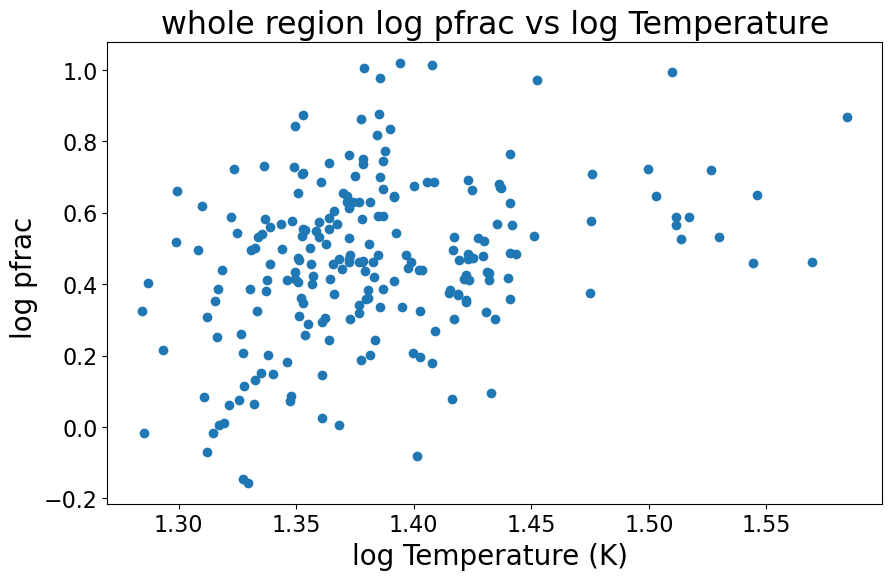

In [24]:
nh2_median = np.nanmedian(nh2_array_ind)
alpha_nh2 = -0.43
p_decol_nh2 = p_array_ind*((nh2_median/nh2_array_ind)**alpha_nh2)
log_p = np.log10(p_decol_nh2)
log_temp = np.log10(temp_array_ind)


plt.figure(figsize =(10, 6))
plt.scatter(log_temp,log_p)
plt.title('whole region log pfrac vs log Temperature')
plt.ylabel('log pfrac ',fontdict={'fontsize':20})
plt.xlabel('log Temperature (K) ',fontdict={'fontsize':20})
plt.show()

Temperature analysis of ridge region

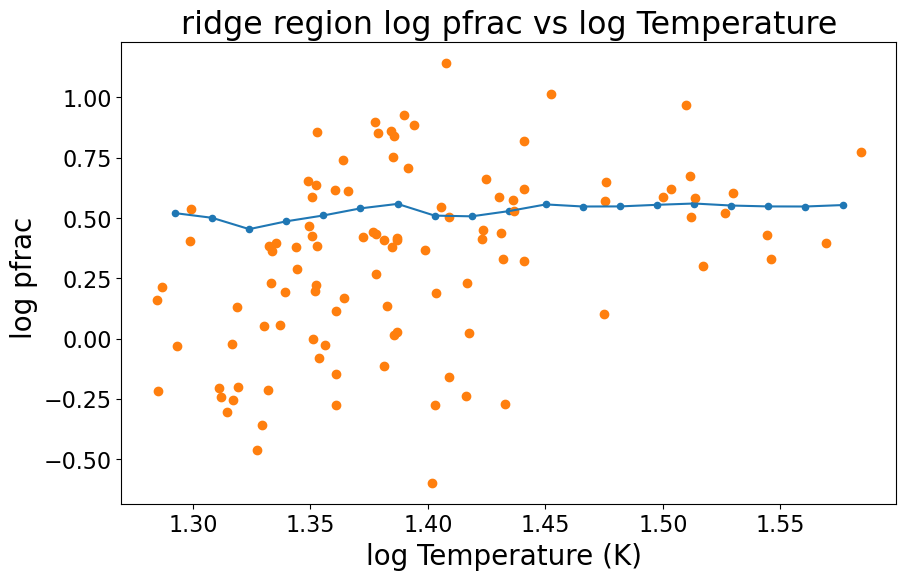

In [25]:
####### changing data to array
s_ridge_array = s_ridge.data.flatten()
p_ridge_array = p_ridge.data.flatten()
I_ridge_array = I_ridge.data.flatten()
nh2_ridge_array = nh2_ridge.data.flatten()
micron8_ridge_array = micron8_ridge.data.flatten()
temp_ridge_array = temp_ridge.data.flatten()

######## making the data points independent
s_ridge_array_ind = s_ridge_array.copy()
s_ridge_array_ind = s_ridge_array_ind[::4]
p_ridge_array_ind = p_ridge_array.copy()
p_ridge_array_ind = p_ridge_array_ind[::4]
I_ridge_array_ind = I_ridge_array.copy()
I_ridge_array_ind = I_ridge_array_ind[::4]
nh2_ridge_array_ind = nh2_ridge_array.copy()
nh2_ridge_array_ind = nh2_ridge_array_ind[::4]
micron8_ridge_array_ind = micron8_ridge_array.copy()
micron8_ridge_array_ind = micron8_ridge_array_ind[::4]
temp_ridge_array_ind = temp_ridge_array.copy()
temp_ridge_array_ind = temp_ridge_array_ind[::4]

######### taking log10 of the data
log_s_ridge = np.log10(s_ridge_array_ind)
log_p_ridge = np.log10(p_ridge_array_ind)
log_I = np.log10(I_ridge_array_ind)
log_nh2_ridge = np.log10(nh2_ridge_array_ind)
log_8micron = np.log10(micron8_ridge_array_ind)
log_temp_ridge = np.log10(temp_ridge_array_ind)

###### making bins for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
temp_min = np.nanmin(log_temp)
temp_max = np.nanmax(log_temp)

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)
temp_bins = np.linspace(temp_min,temp_max,100)

# plt.figure(figsize =(10, 6))
# plt.scatter(nh2_ridge_array_ind,p_ridge_array_ind,c = temp_ridge_array_ind,cmap='jet')
# plt.colorbar(label = 'Temp (K)')
# plt.clim(18, 37.5) 
# plt.title('ridge region pfrac vs Column Density')
# plt.ylabel(' pfrac ',fontdict={'fontsize':20})
# plt.xlabel('Column Density ',fontdict={'fontsize':20})
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

# plt.figure(figsize =(10, 6))
# plt.scatter(s_ridge_array_ind,p_ridge_array_ind,c = temp_ridge_array_ind,cmap='jet')
# plt.colorbar(label = 'Temp (K)')
# plt.clim(18, 37.5) 
# plt.title('ridge region log pfrac vs log S')
# plt.ylabel('log pfrac ',fontdict={'fontsize':20})
# plt.xlabel('log S ',fontdict={'fontsize':20})
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

# plt.figure(figsize =(10, 6))
# plt.scatter(log_temp_ridge,log_p_ridge,c = log_nh2,cmap='jet')
# plt.colorbar(label = 'log NH2')
# plt.title('ridge region log pfrac vs log Temperature')
# plt.ylabel('log pfrac ',fontdict={'fontsize':20})
# plt.xlabel('log Temperature (K) ',fontdict={'fontsize':20})
# plt.show()

def binning_data_hist2D(array1,array2,delt_bin):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
    binned_data_bins = np.linspace(np.amin(binned_data),np.amax(binned_data),10)
    # plt.figure(figsize=(10,6))
    cmap_reversed = matplotlib.cm.get_cmap('jet')
    plt.scatter(levels_centres,binned_data,s = 20)
    plt.plot(levels_centres,binned_data,label = 'bins :' + str(delt_bin))



plt.figure(figsize =(10, 6))
binning_data_hist2D(log_temp,log_p,20)
plt.scatter(log_temp_ridge,log_p_ridge)
plt.title('ridge region log pfrac vs log Temperature')
plt.ylabel('log pfrac ',fontdict={'fontsize':20})
plt.xlabel('log Temperature (K) ',fontdict={'fontsize':20})
plt.show()

# plt.figure(figsize =(10, 6))
# binning_data_hist2D(log_temp,log_nh2,20)
# plt.scatter(log_temp_ridge,log_nh2_ridge)
# plt.title('ridge region log NH2vs log Temperature')
# plt.ylabel('log NH2 ',fontdict={'fontsize':20})
# plt.xlabel('log Temperature (K) ',fontdict={'fontsize':20})
# plt.show()

# plt.figure(figsize =(10, 6))
# binning_data_hist2D(log_nh2,log_p,20)
# plt.scatter(log_nh2_ridge,log_p_ridge)
# plt.title('ridge region log pfrac vs log NH2')
# plt.ylabel('log pfrac ',fontdict={'fontsize':20})
# plt.xlabel('log NH2 ',fontdict={'fontsize':20})
# plt.show()

Temperature analysis of sub-fil region

In [26]:
####### changing data to array

s_fil_right_array = s_fil_right.data.flatten()
p_fil_right_array = p_fil_right.data.flatten()
I_fil_right_array = I_fil_right.data.flatten()
nh2_fil_right_array = nh2_fil_right.data.flatten()
micron8_fil_right_array = micron8_fil_right.data.flatten()
temp_fil_right_array = temp_fil_right.data.flatten()


######## making the data points independent
s_fil_right_array_ind = s_fil_right_array.copy()
s_fil_right_array_ind = s_fil_right_array_ind[::4]
p_fil_right_array_ind = p_fil_right_array.copy()
p_fil_right_array_ind = p_fil_right_array_ind[::4]
I_fil_right_array_ind = I_fil_right_array.copy()
I_fil_right_array_ind = I_fil_right_array_ind[::4]
nh2_fil_right_array_ind = nh2_fil_right_array.copy()
nh2_fil_right_array_ind = nh2_fil_right_array_ind[::4]
micron8_fil_right_array_ind = micron8_fil_right_array.copy()
micron8_fil_right_array_ind = micron8_fil_right_array_ind[::4]
temp_fil_right_array_ind = temp_fil_right_array.copy()
temp_fil_right_array_ind = temp_fil_right_array_ind[::4]

######## taking log10 of the data
log_s = np.log10(s_fil_right_array_ind)
log_p = np.log10(p_fil_right_array_ind)
log_I = np.log10(I_fil_right_array_ind)
log_nh2 = np.log10(nh2_fil_right_array_ind)
log_8micron = np.log10(micron8_fil_right_array_ind)
log_temp = np.log10(temp_fil_right_array_ind)


###### making bins for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
temp_min = np.nanmin(log_temp)
temp_max = np.nanmax(log_temp)

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)
temp_bins = np.linspace(temp_min,temp_max,100)

# plt.figure(figsize =(10, 6))
# plt.scatter(nh2_fil_right_array_ind,p_fil_right_array_ind,c = temp_fil_right_array_ind,cmap='jet')
# plt.colorbar(label = 'Temp (K)')
# plt.clim(18, 37.5) 
# plt.title('sub-fil region pfrac vs Column Density')
# plt.ylabel(' pfrac ',fontdict={'fontsize':20})
# plt.xlabel(' Column Density ',fontdict={'fontsize':20})
# plt.xscale('log')
# plt.yscale('log')
# plt.xticks([1e22,2e22,4e22,8e22,1e23])
# plt.tight_layout()
# plt.show()

# plt.figure(figsize =(10, 6))
# plt.scatter(s_fil_right_array_ind,p_fil_right_array_ind,c = temp_fil_right_array_ind,cmap='jet')
# plt.colorbar(label = 'Temp (K)')
# plt.clim(18, 37.5) 
# plt.title('sub-fil region pfrac vs  S')
# plt.ylabel(' pfrac ',fontdict={'fontsize':20})
# plt.xlabel(' S ',fontdict={'fontsize':20})
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


# plt.figure(figsize =(10, 6))
# plt.scatter(log_temp,log_p,c = log_nh2,cmap='jet')
# plt.colorbar(label = 'log NH2')
# plt.title('sub-fil region log pfrac vs log Temperature')
# plt.ylabel('log pfrac ',fontdict={'fontsize':20})
# plt.xlabel('log Temperature (K) ',fontdict={'fontsize':20})
# plt.show()

# plt.figure(figsize =(10, 6))
# plt.scatter(log_temp,log_p)
# plt.title('sub-fil region log pfrac vs log Temperature')
# plt.ylabel('log pfrac ',fontdict={'fontsize':20})
# plt.xlabel('log Temperature (K) ',fontdict={'fontsize':20})
# plt.show()

# def binning_data_hist2D(array1,array2,delt_bin,region):
#     levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
#     levels_centres = (levels[:-1] + levels[1:])/2
#     binned_data = []
#     for i in range(levels.shape[0]-1):
#         temp_array2 = array2.copy()
#         Selector = array1 < levels[i]
#         temp_array2[Selector] = np.nan
#         Selector =  array1 > levels[i+1]
#         temp_array2[Selector] =np.nan
#         binned_data.append(np.nanmean(temp_array2))
#     binned_data_bins = np.linspace(np.amin(binned_data),np.amax(binned_data),10)
#     # plt.figure(figsize=(10,6))
#     cmap_reversed = matplotlib.cm.get_cmap('jet')
#     plt.scatter(levels_centres,binned_data,s = 20)
#     plt.plot(levels_centres,binned_data,label = region)


plt.figure(figsize =(10, 6))
binning_data_hist2D(log_nh2,log_p,10,'sub-fil')
binning_data_hist2D(log_nh2_ridge,log_p_ridge,10,'ridge')
plt.scatter(log_nh2_ridge,log_p_ridge,label = 'ridge')
plt.scatter(log_nh2,log_p,label = 'sub-fil')
plt.title('ridge - sub-fil region log pfrac vs log NH2')
plt.ylabel('log pfrac ',fontdict={'fontsize':20})
plt.xlabel('log NH2 ',fontdict={'fontsize':20})
plt.legend()
plt.show()

plt.figure(figsize =(10, 6))
binning_data_hist2D(log_s,log_p,10,'sub-fil')
binning_data_hist2D(log_s_ridge,log_p_ridge,10,'ridge')
plt.scatter(log_s_ridge,log_p_ridge,label = 'ridge')
plt.scatter(log_s,log_p,label = 'sub-fil')
plt.title('ridge - sub-fil region log pfrac vs log S')
plt.ylabel('log pfrac ',fontdict={'fontsize':20})
plt.xlabel('log S ',fontdict={'fontsize':20})
plt.legend()
plt.show()

TypeError: binning_data_hist2D() takes 3 positional arguments but 4 were given

<Figure size 1000x600 with 0 Axes>

: 